In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

from PIL import Image
from IPython.display import display
import cv2
from PIL import ImageFile
import torchvision.transforms as transforms
ImageFile.LOAD_TRUNCATED_IMAGES = True

import glob
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
def seed_everything(seed=1234):
    random.seed(seed) # 设置Python内置random模块的种子影响：random.randint(), random.choice(), random.shuffle() 等函数
    os.environ['PYTHONHASHSEED'] = str(seed) # 设置Python哈希种子,作用：确保字典、集合等数据结构的哈希行为一致
    np.random.seed(seed)  # 设置NumPy的随机种子,影响：np.random.rand(), np.random.randint() 等NumPy随机函数
    torch.manual_seed(seed) # 设置PyTorch的CPU随机种子
    torch.cuda.manual_seed(seed) # 设置PyTorch的GPU随机种子,影响PyTorch在GPU上的随机操作（如dropout、初始化等）
    torch.backends.cudnn.deterministic = True # 确保CuDNN使用确定性算法,作用：禁用CuDNN的非确定性算法，确保GPU计算结果可重现代价：可能会稍微降低性能
seed_everything(42)

In [3]:
#Read the dataset 
PATH = './dataset/'
labels = pd.read_csv(PATH+'labels.csv')
labelnames = pd.read_csv(PATH + 'sample_submission.csv').keys()[1:] # 获取出第一列以外所有列的名字
print("Train folder has ", len(os.listdir(PATH+'train')),'images which matches with label\'s', len(labels),'images')

Train folder has  10222 images which matches with label's 10222 images


In [4]:
codes = range(len(labelnames))
breed_to_code = dict(zip(labelnames, codes))
code_to_breed = dict(zip(codes, labelnames))
labels['target'] =  [breed_to_code[x] for x in labels.breed]
# 在每个品种组内，基于'id'列计算排名用于标识每个品种内样本的顺序
labels['rank'] = labels.groupby('breed').rank()['id']
# aggfunc='first'：如果有重复，取第一个值，fillna(0)：用0填充缺失值
labels_pivot = labels.pivot_table(index='id', columns='breed', values='target', aggfunc='first').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.85)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)
# 120种狗+1 id=121

(8689, 121) (1533, 121)


In [5]:
labels.head(5)

id             breed  target  rank
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull      19   1.0
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo      37   1.0
2  001cdf01b096e06d78e9e5112d419397          pekinese      85   1.0
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick      15   1.0
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever      49   1.0

In [6]:
from data.dataset import DogBreedDataset,img_transform
batch_size = 12
num_workers = 4
train_img = DogBreedDataset(PATH+'train/', train, transform = img_transform['train'])
valid_img = DogBreedDataset(PATH+'train/', valid, transform = img_transform['valid'])


dataloaders={
    'train':torch.utils.data.DataLoader(train_img, batch_size, num_workers = num_workers, shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_img, batch_size, num_workers = num_workers, shuffle=False)
}


In [7]:
use_cuda = torch.cuda.is_available()


In [8]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([12, 3, 224, 224]) torch.Size([12])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9294117405414581].
Clip

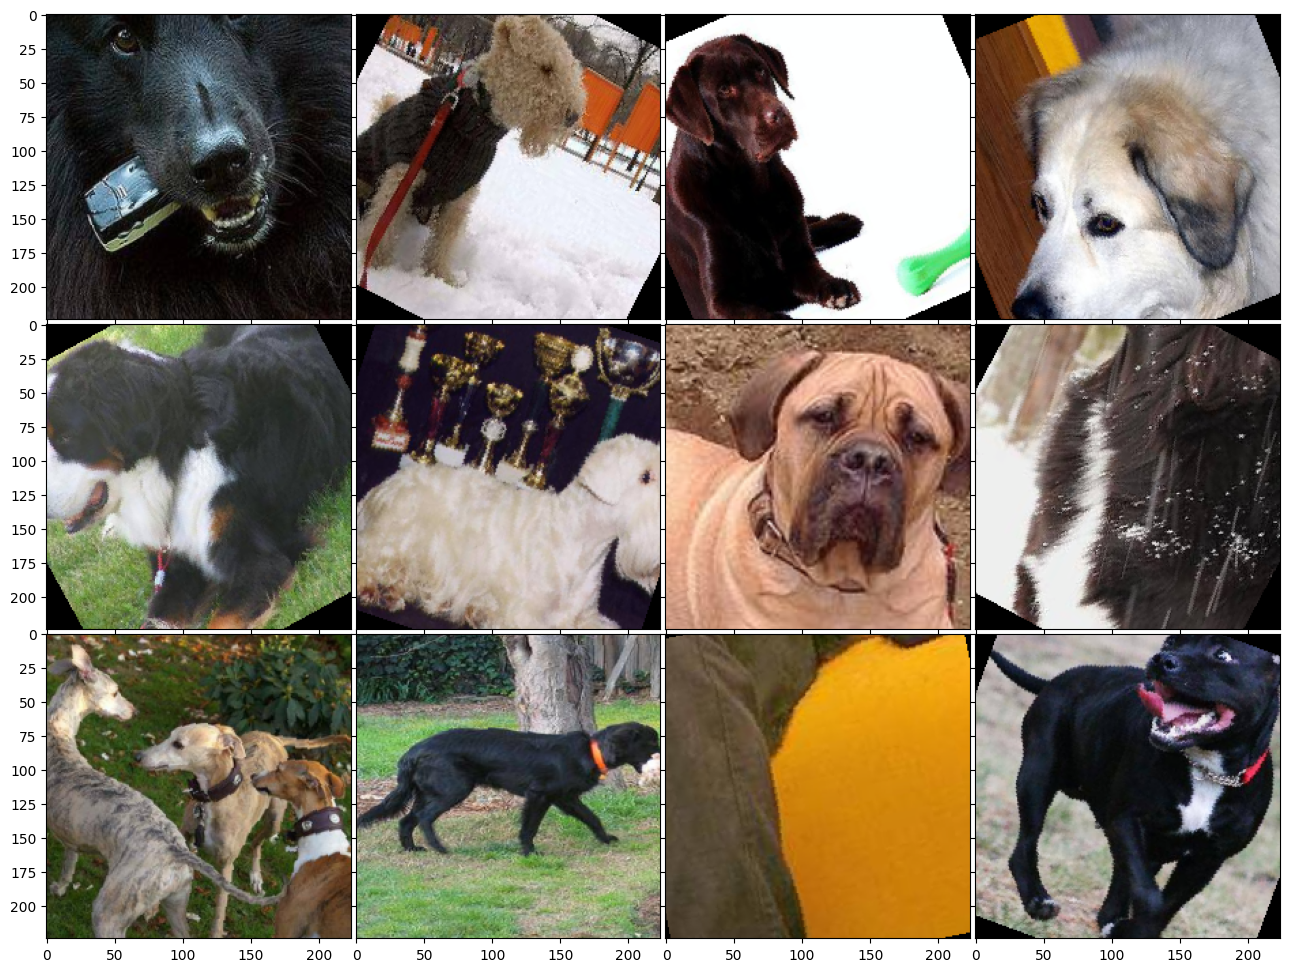

In [9]:
# 数据集图片展示
from mpl_toolkits.axes_grid1 import ImageGrid
img, label = next(iter(dataloaders['train']))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

In [10]:
from visualize.plot_loss import plot_multiple_metrics_by_epoch
from utils.train import transfer_train
def multi_model_transfer_learning(models,n_epochs):
    train_losses_list=[]
    valid_losses_list=[]
    train_accuracies_list=[]
    valid_accuracies_list=[]
    models_name=[model.__class__.__name__.lower() for model in models]
    for model in models:
        _,train_losses,valid_losses,train_accuracies,valid_accuracies=transfer_train(model,dataloaders,n_epochs=n_epochs)
        train_losses_list.append(train_losses)
        valid_losses_list.append(valid_losses)
        train_accuracies_list.append(train_accuracies)
        valid_accuracies_list.append(valid_accuracies)
    return train_losses_list,valid_losses_list,train_accuracies_list,valid_accuracies_list,models_name

In [11]:
from utils.ensemble_learning import ResNetFeatureExtractor, SENetFeatureExtractor,FeatureFusionEnsemble   
from models.SeResnet import se_resnext101

alexnet = models.alexnet(pretrained=True)
googlenet = models.googlenet(pretrained=True)
resnet101 = models.resnet101(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
densenet121 = models.densenet121(pretrained=True)
efficientnet_b0 = models.efficientnet_b0(pretrained=True)
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
senet101=se_resnext101(pretrained="imagenet")
resnet_feat = ResNetFeatureExtractor(resnet101)
senet_feat  = SENetFeatureExtractor(senet101)

fusion_model = FeatureFusionEnsemble(
    resnet_feat, 
    senet_feat, 
    num_classes=120
)
# 冻结所有特征提取层
for p in fusion_model.m1.parameters():
    p.requires_grad = False
for p in fusion_model.m2.parameters():
    p.requires_grad = False

# 只训练新加的分类头
for p in fusion_model.classifier.parameters():
    p.requires_grad = True
models_list=[alexnet,googlenet,resnet101,vgg16,densenet121,efficientnet_b0,mobilenet_v2,senet101,fusion_model]
train_losses_list,valid_losses_list,train_accuracies_list,valid_accuracies_list,models_name= multi_model_transfer_learning(models_list,25)


New classification layer moved to GPU
Model already exists, loading from ./model_weight/alexnet_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exists, loading from ./model_weight/googlenet_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exists, loading from ./model_weight/resnet_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exists, loading from ./model_weight/vgg_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exists, loading from ./model_weight/densenet_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exists, loading from ./model_weight/efficientnet_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exists, loading from ./model_weight/mobilenetv2_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exi

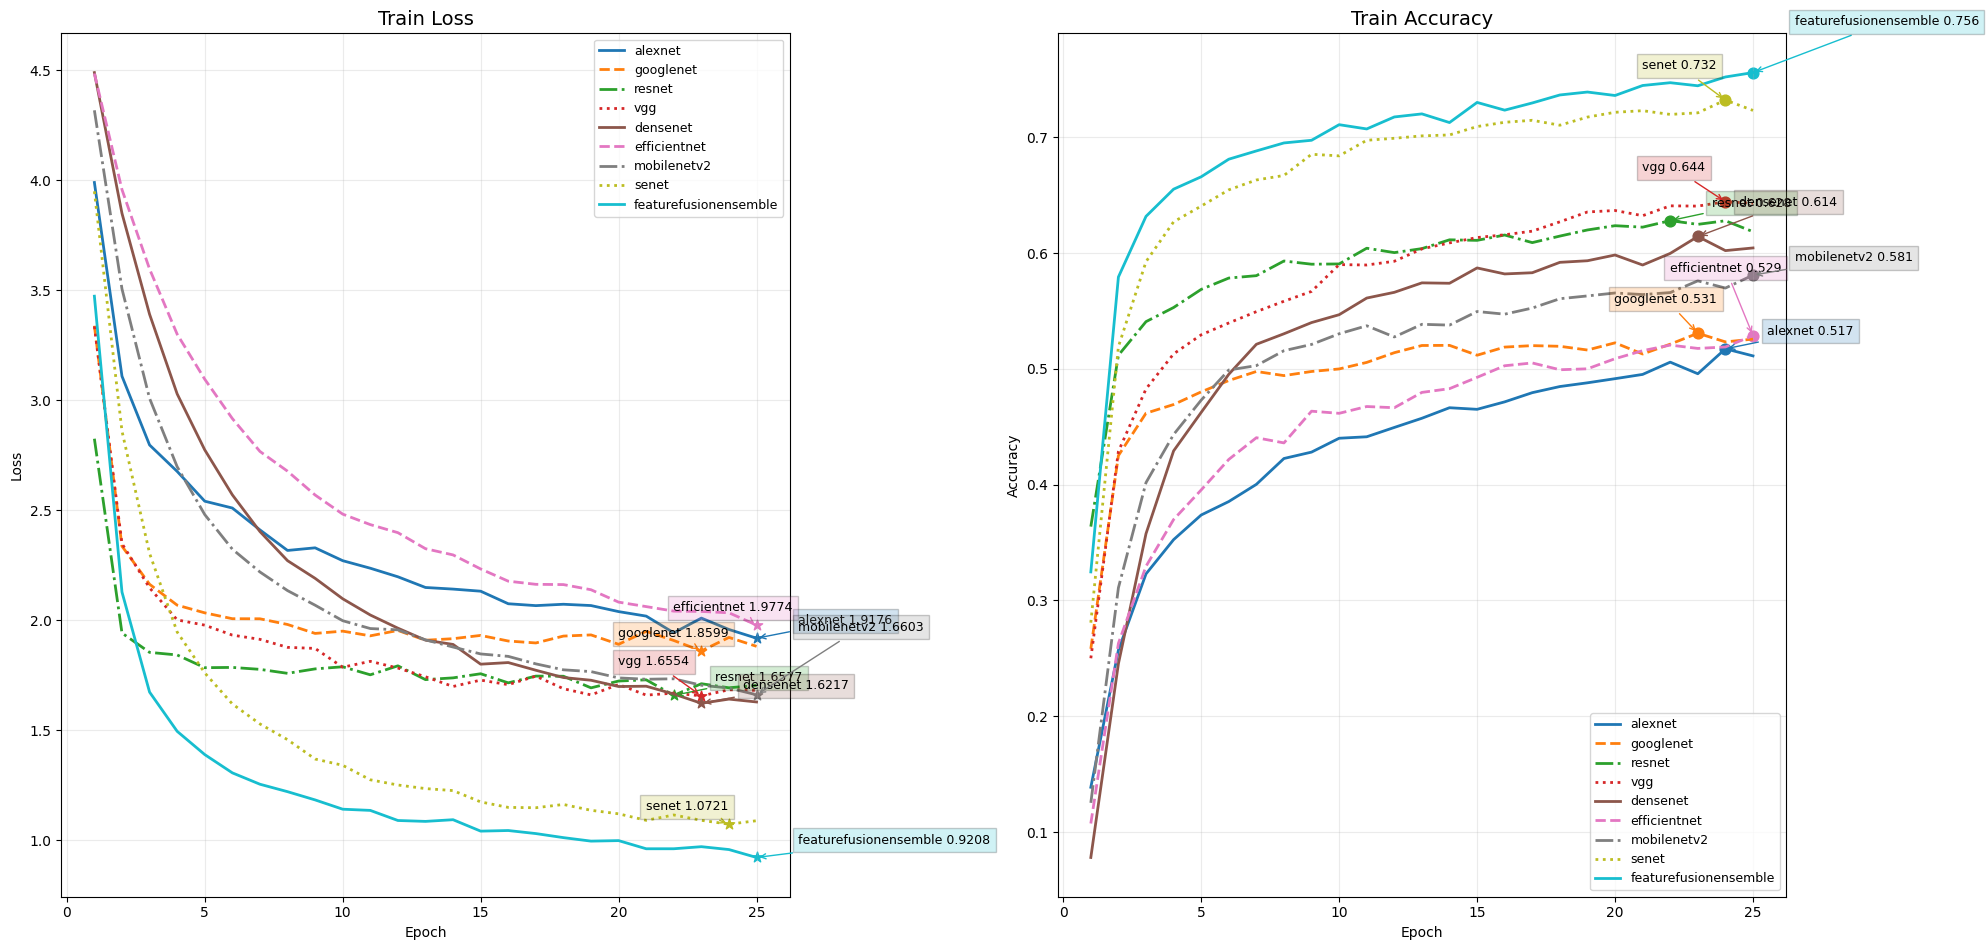

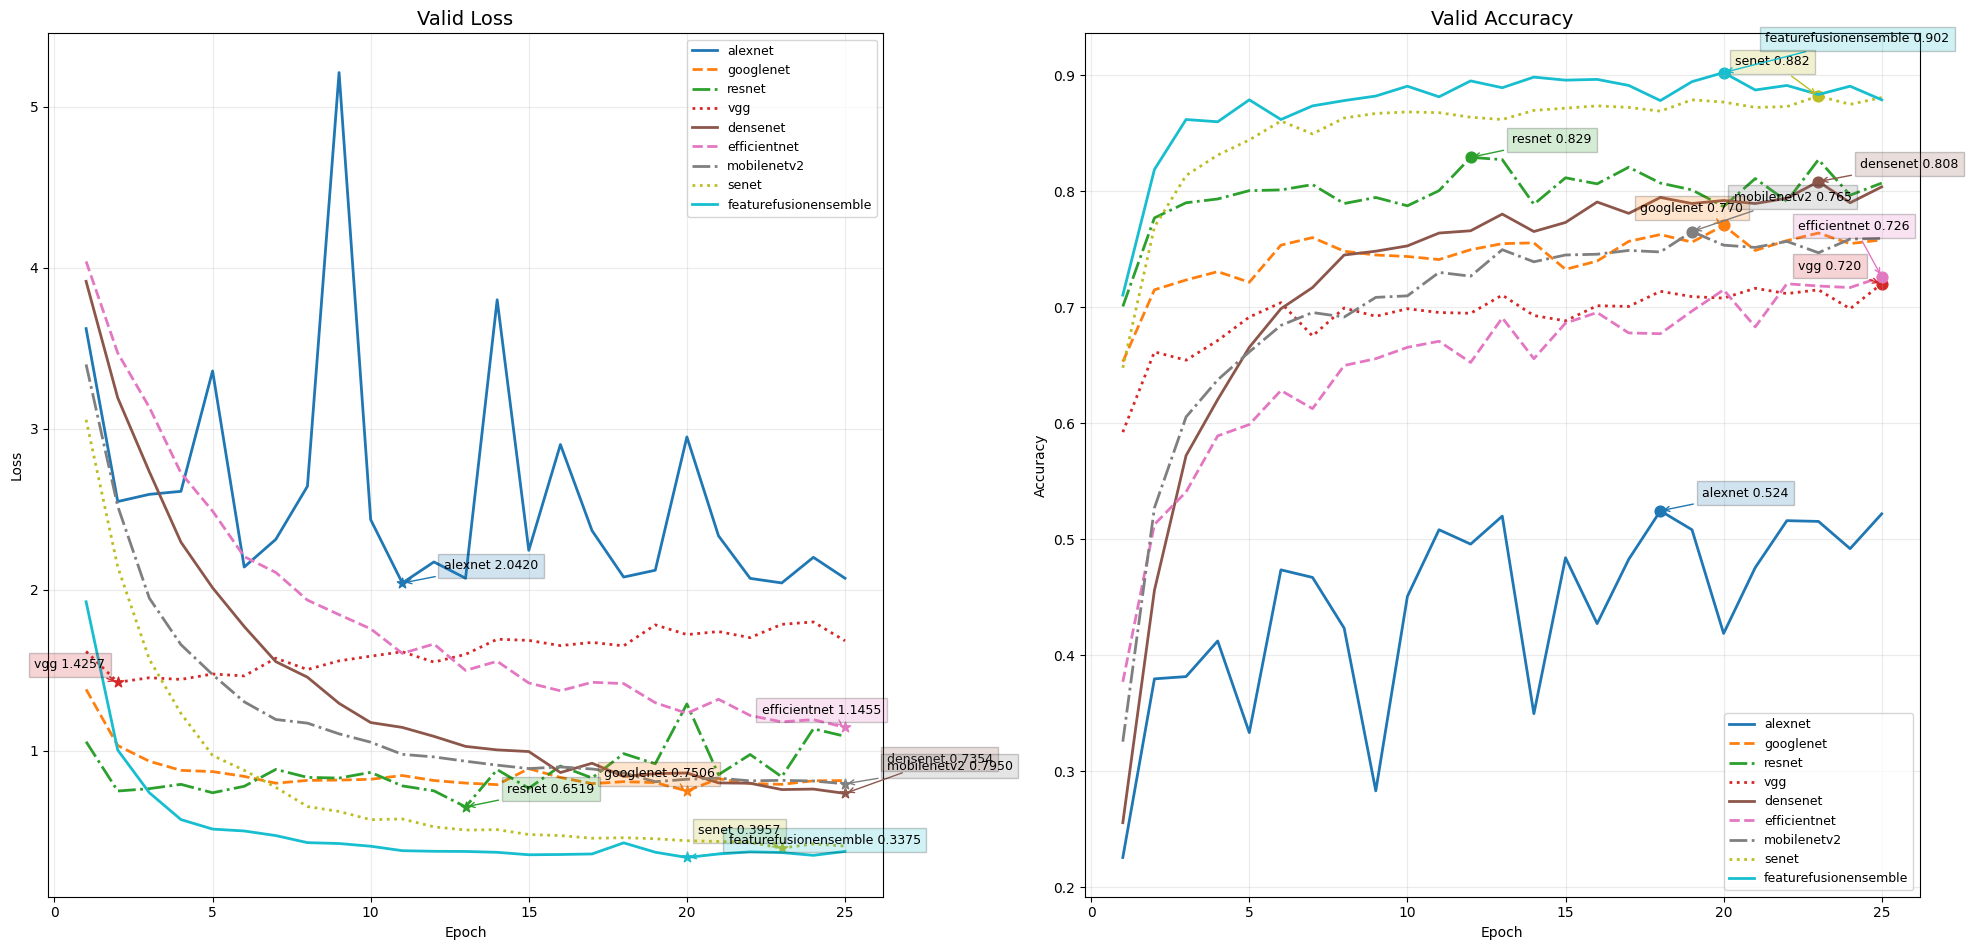

In [12]:
plot_multiple_metrics_by_epoch(
        train_losses_list, valid_losses_list,\
        train_accuracies_list, valid_accuracies_list,\
        models_name, n_epochs=25
)

In [ ]:
# 可视化feature map
import numpy as np
import matplotlib.pyplot as plt
from openTSNE import TSNE
import torch

from visualize.dimension_reduction_visualize import plot_tsne_features_2d,plot_tsne_features_3d
from utils.feature_extract import extract_features_map
features_array,labels_array=extract_features_map(senet101,dataloaders['valid'],use_cuda=use_cuda,n_samples=1000,layer_name='fc')

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.90 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.34 seconds
===> Running optimization with exaggeration=12.00, lr=127.75 for 250 iterations...
Iteration   50, KL divergence 3.6526, 50 iterations in 0.2702 sec
Iteration  100, KL divergence 3.5927, 50 iterations in 0.1943 sec
Iteration  150, KL divergence 3.5932, 50 iterations in 0.1790 sec
Iteration  200, KL divergence 3.5934, 50 iterations in 0.2095 sec
Iteration  250, KL divergence 3.5927, 50 iterations in 0.2418 sec
   --> Time elapsed: 1.10 seconds
===> Running optimization with exaggeration=1.

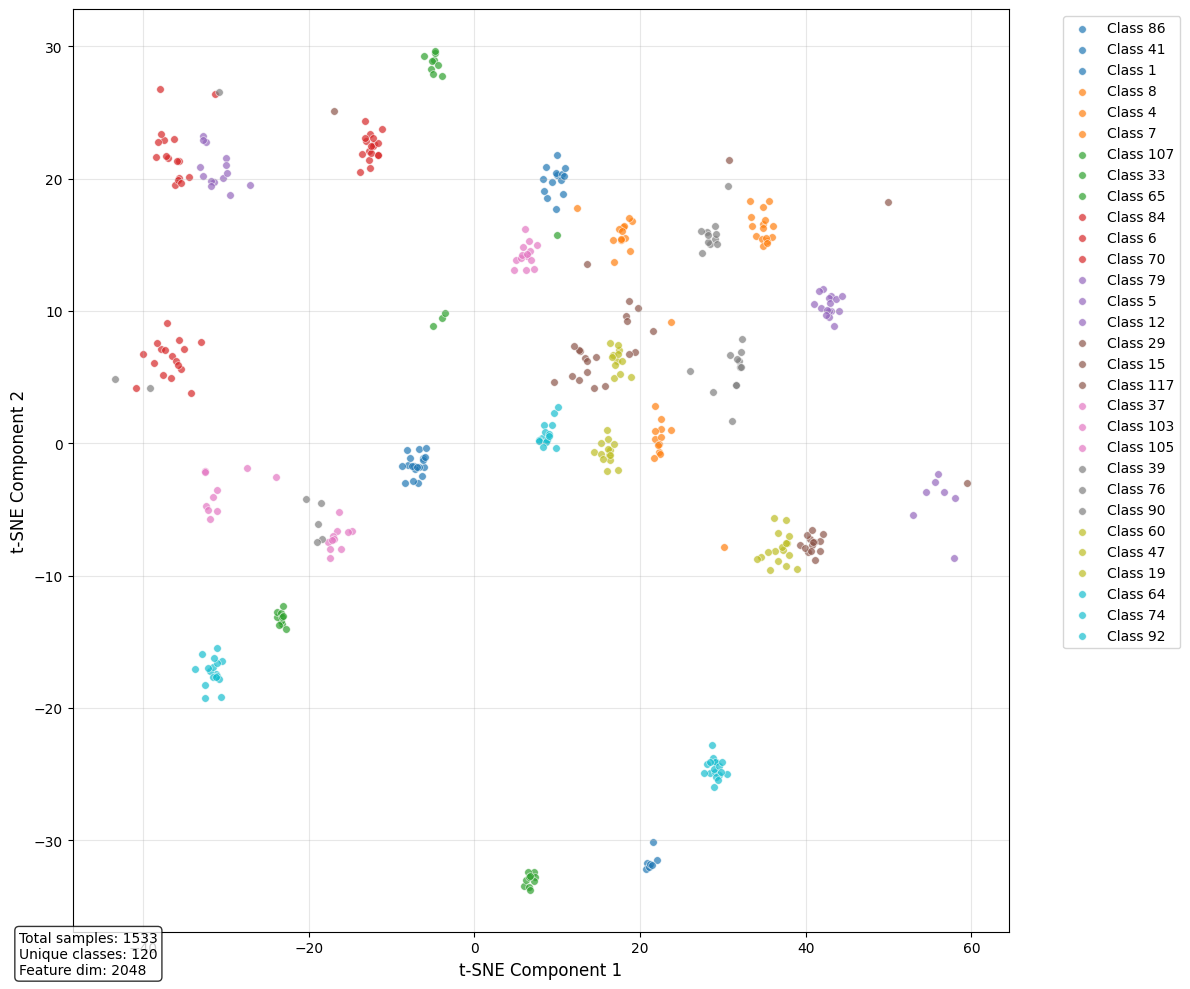

t-SNE可视化完成! 图像保存为: senet101_tsne_features_2d.png


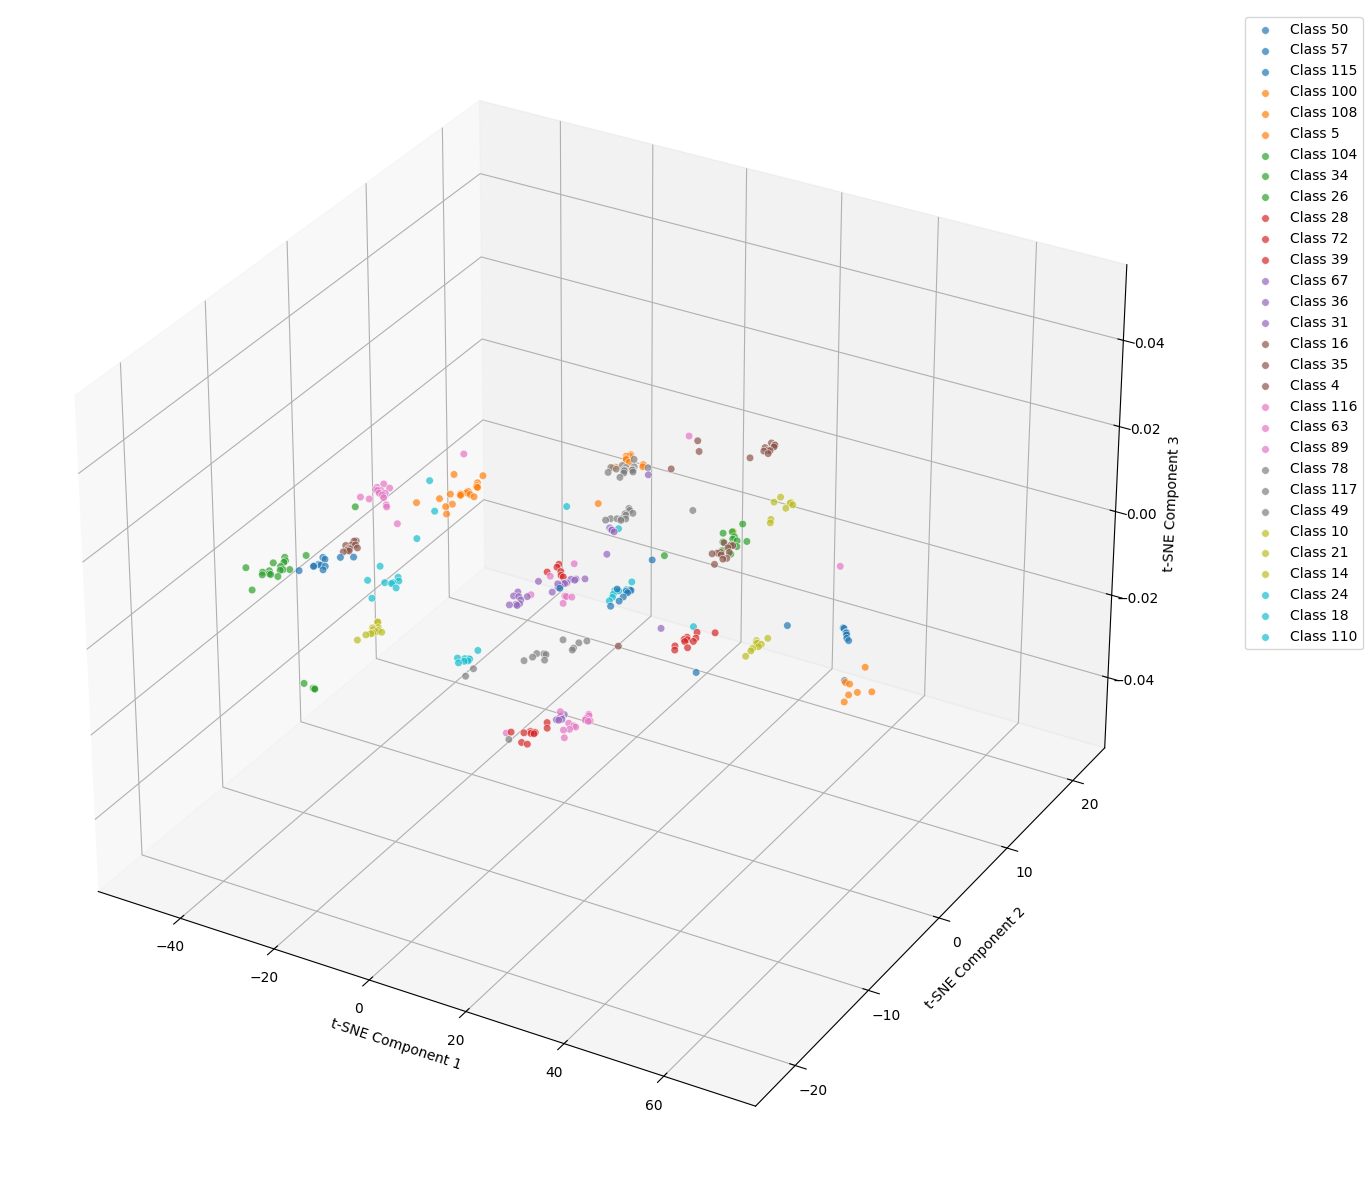

t-SNE可视化完成! 图像保存为: senet101_tsne_features_3d.png


In [ ]:
plot_tsne_features_2d(features_array, labels_array, "senet101")
plot_tsne_features_3d(features_array, labels_array, "senet101")

In [ ]:
# 提取训练集和验证集的特征
from utils.feature_extract import extract_features_map
print("提取训练集特征...")
features_train, labels_train = extract_features_map(
    senet101, dataloaders['train'], use_cuda=use_cuda, n_samples=1000
)
print("\n提取验证集特征...")
features_valid, labels_valid = extract_features_map(
    senet101, dataloaders['valid'], use_cuda=use_cuda, n_samples=1000
)

提取训练集特征...
开始提取特征...


已处理 10 个样本...
已处理 20 个样本...
已处理 30 个样本...
已处理 40 个样本...
已处理 50 个样本...
已处理 60 个样本...
已处理 70 个样本...
已处理 80 个样本...
已处理 90 个样本...
已处理 100 个样本...
已处理 110 个样本...
已处理 120 个样本...
已处理 130 个样本...
已处理 140 个样本...
已处理 150 个样本...
已处理 160 个样本...
已处理 170 个样本...
已处理 180 个样本...
已处理 190 个样本...
已处理 200 个样本...
已处理 210 个样本...
已处理 220 个样本...
已处理 230 个样本...
已处理 240 个样本...
已处理 250 个样本...
已处理 260 个样本...
已处理 270 个样本...
已处理 280 个样本...
已处理 290 个样本...
已处理 300 个样本...
已处理 310 个样本...
已处理 320 个样本...
已处理 330 个样本...
已处理 340 个样本...
已处理 350 个样本...
已处理 360 个样本...
已处理 370 个样本...
已处理 380 个样本...
已处理 390 个样本...
已处理 400 个样本...
已处理 410 个样本...
已处理 420 个样本...
已处理 430 个样本...
已处理 440 个样本...
已处理 450 个样本...
已处理 460 个样本...
已处理 470 个样本...
已处理 480 个样本...
已处理 490 个样本...
已处理 500 个样本...
已处理 510 个样本...
已处理 520 个样本...
已处理 530 个样本...
已处理 540 个样本...
已处理 550 个样本...
已处理 560 个样本...
已处理 570 个样本...
已处理 580 个样本...
已处理 590 个样本...
已处理 600 个样本...
已处理 610 个样本...
已处理 620 个样本...
已处理 630 个样本...
已处理 640 个样本...
已处理 650 个样本...
已处理 660 个样本...
已处理 670 个样本...
已处理 

开始训练SVM分类器...
训练集特征形状: (8689, 2048), 标签形状: (8689,)
测试集特征形状: (1533, 2048), 标签形状: (1533,)
训练线性SVM...
线性SVM准确率: 0.8702

线性SVM分类报告:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        11
           3       0.74      0.93      0.82        15
           4       0.73      0.85      0.79        13
           5       0.60      0.86      0.71         7
           6       0.81      0.87      0.84        15
           7       1.00      1.00      1.00        14
           8       1.00      0.88      0.93        16
           9       0.72      0.86      0.78        21
          10       1.00      0.92      0.96        12
          11       0.83      0.83      0.83        12
          12       0.79      0.94      0.86        16
          13       1.00      0.94      0.97        16
          14       0.69      0.90      0.78        10
       

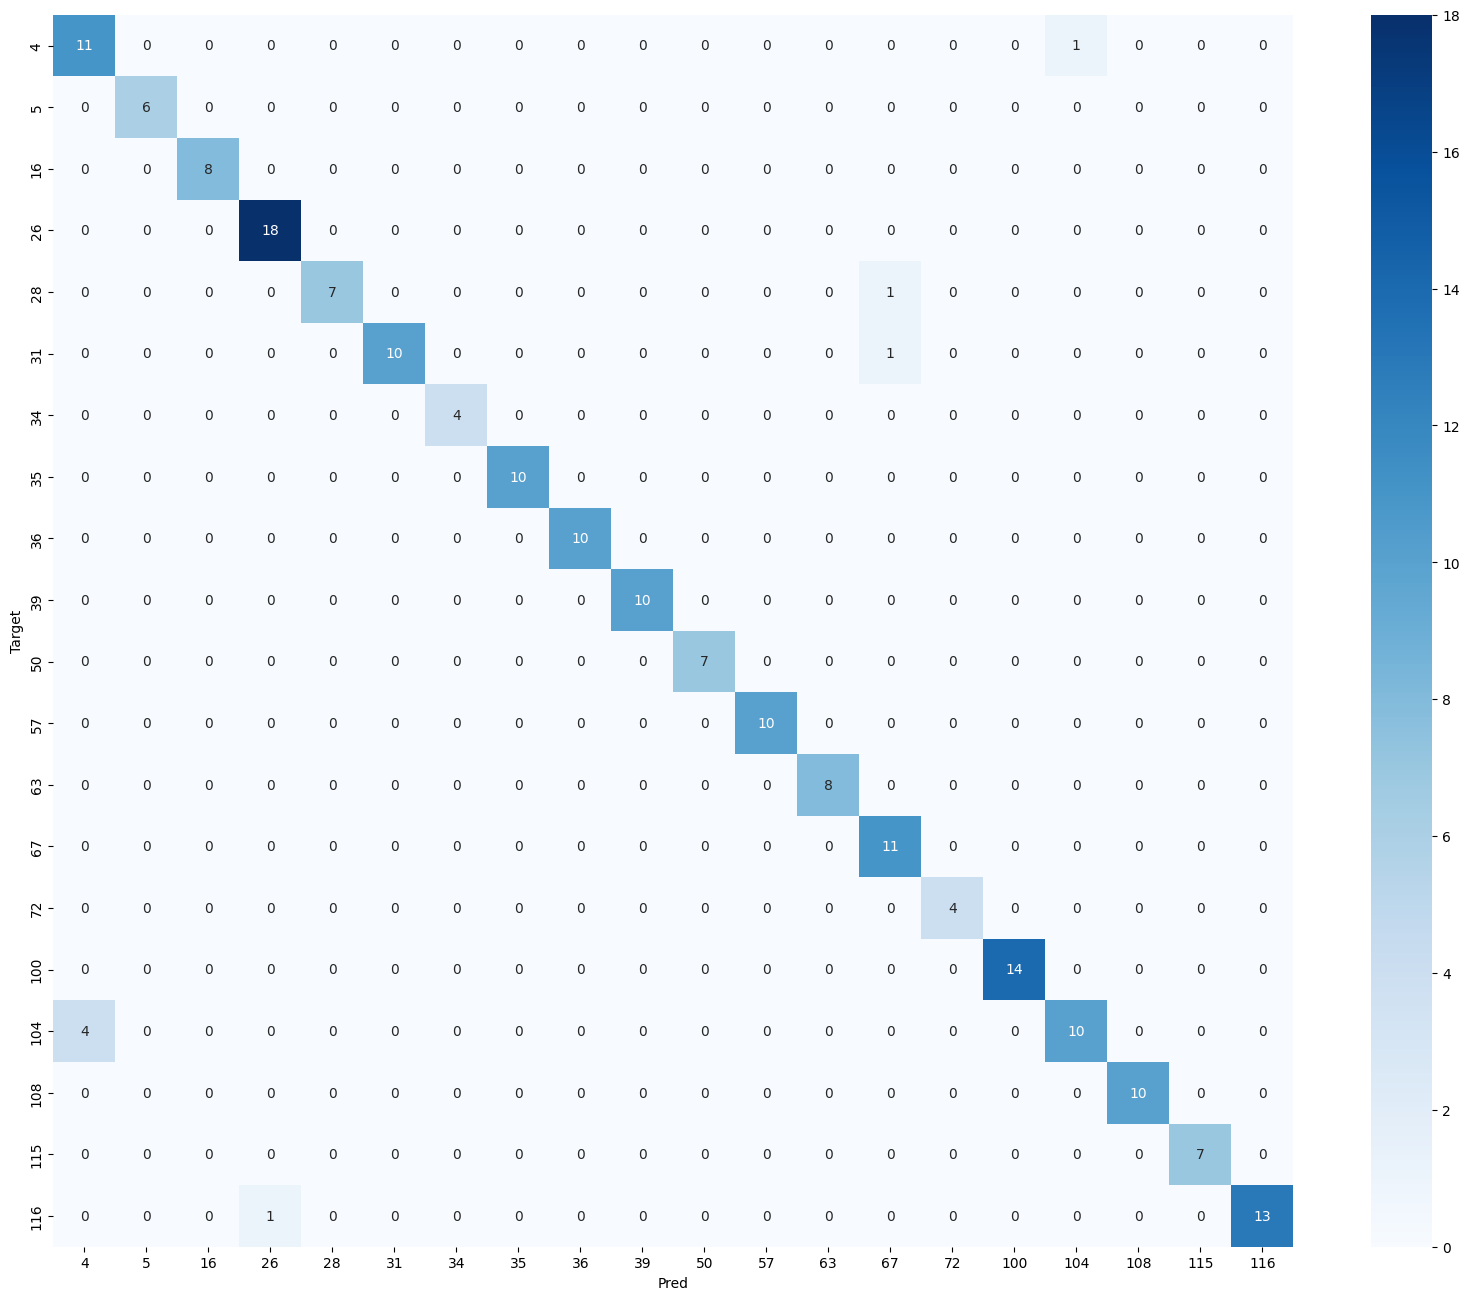

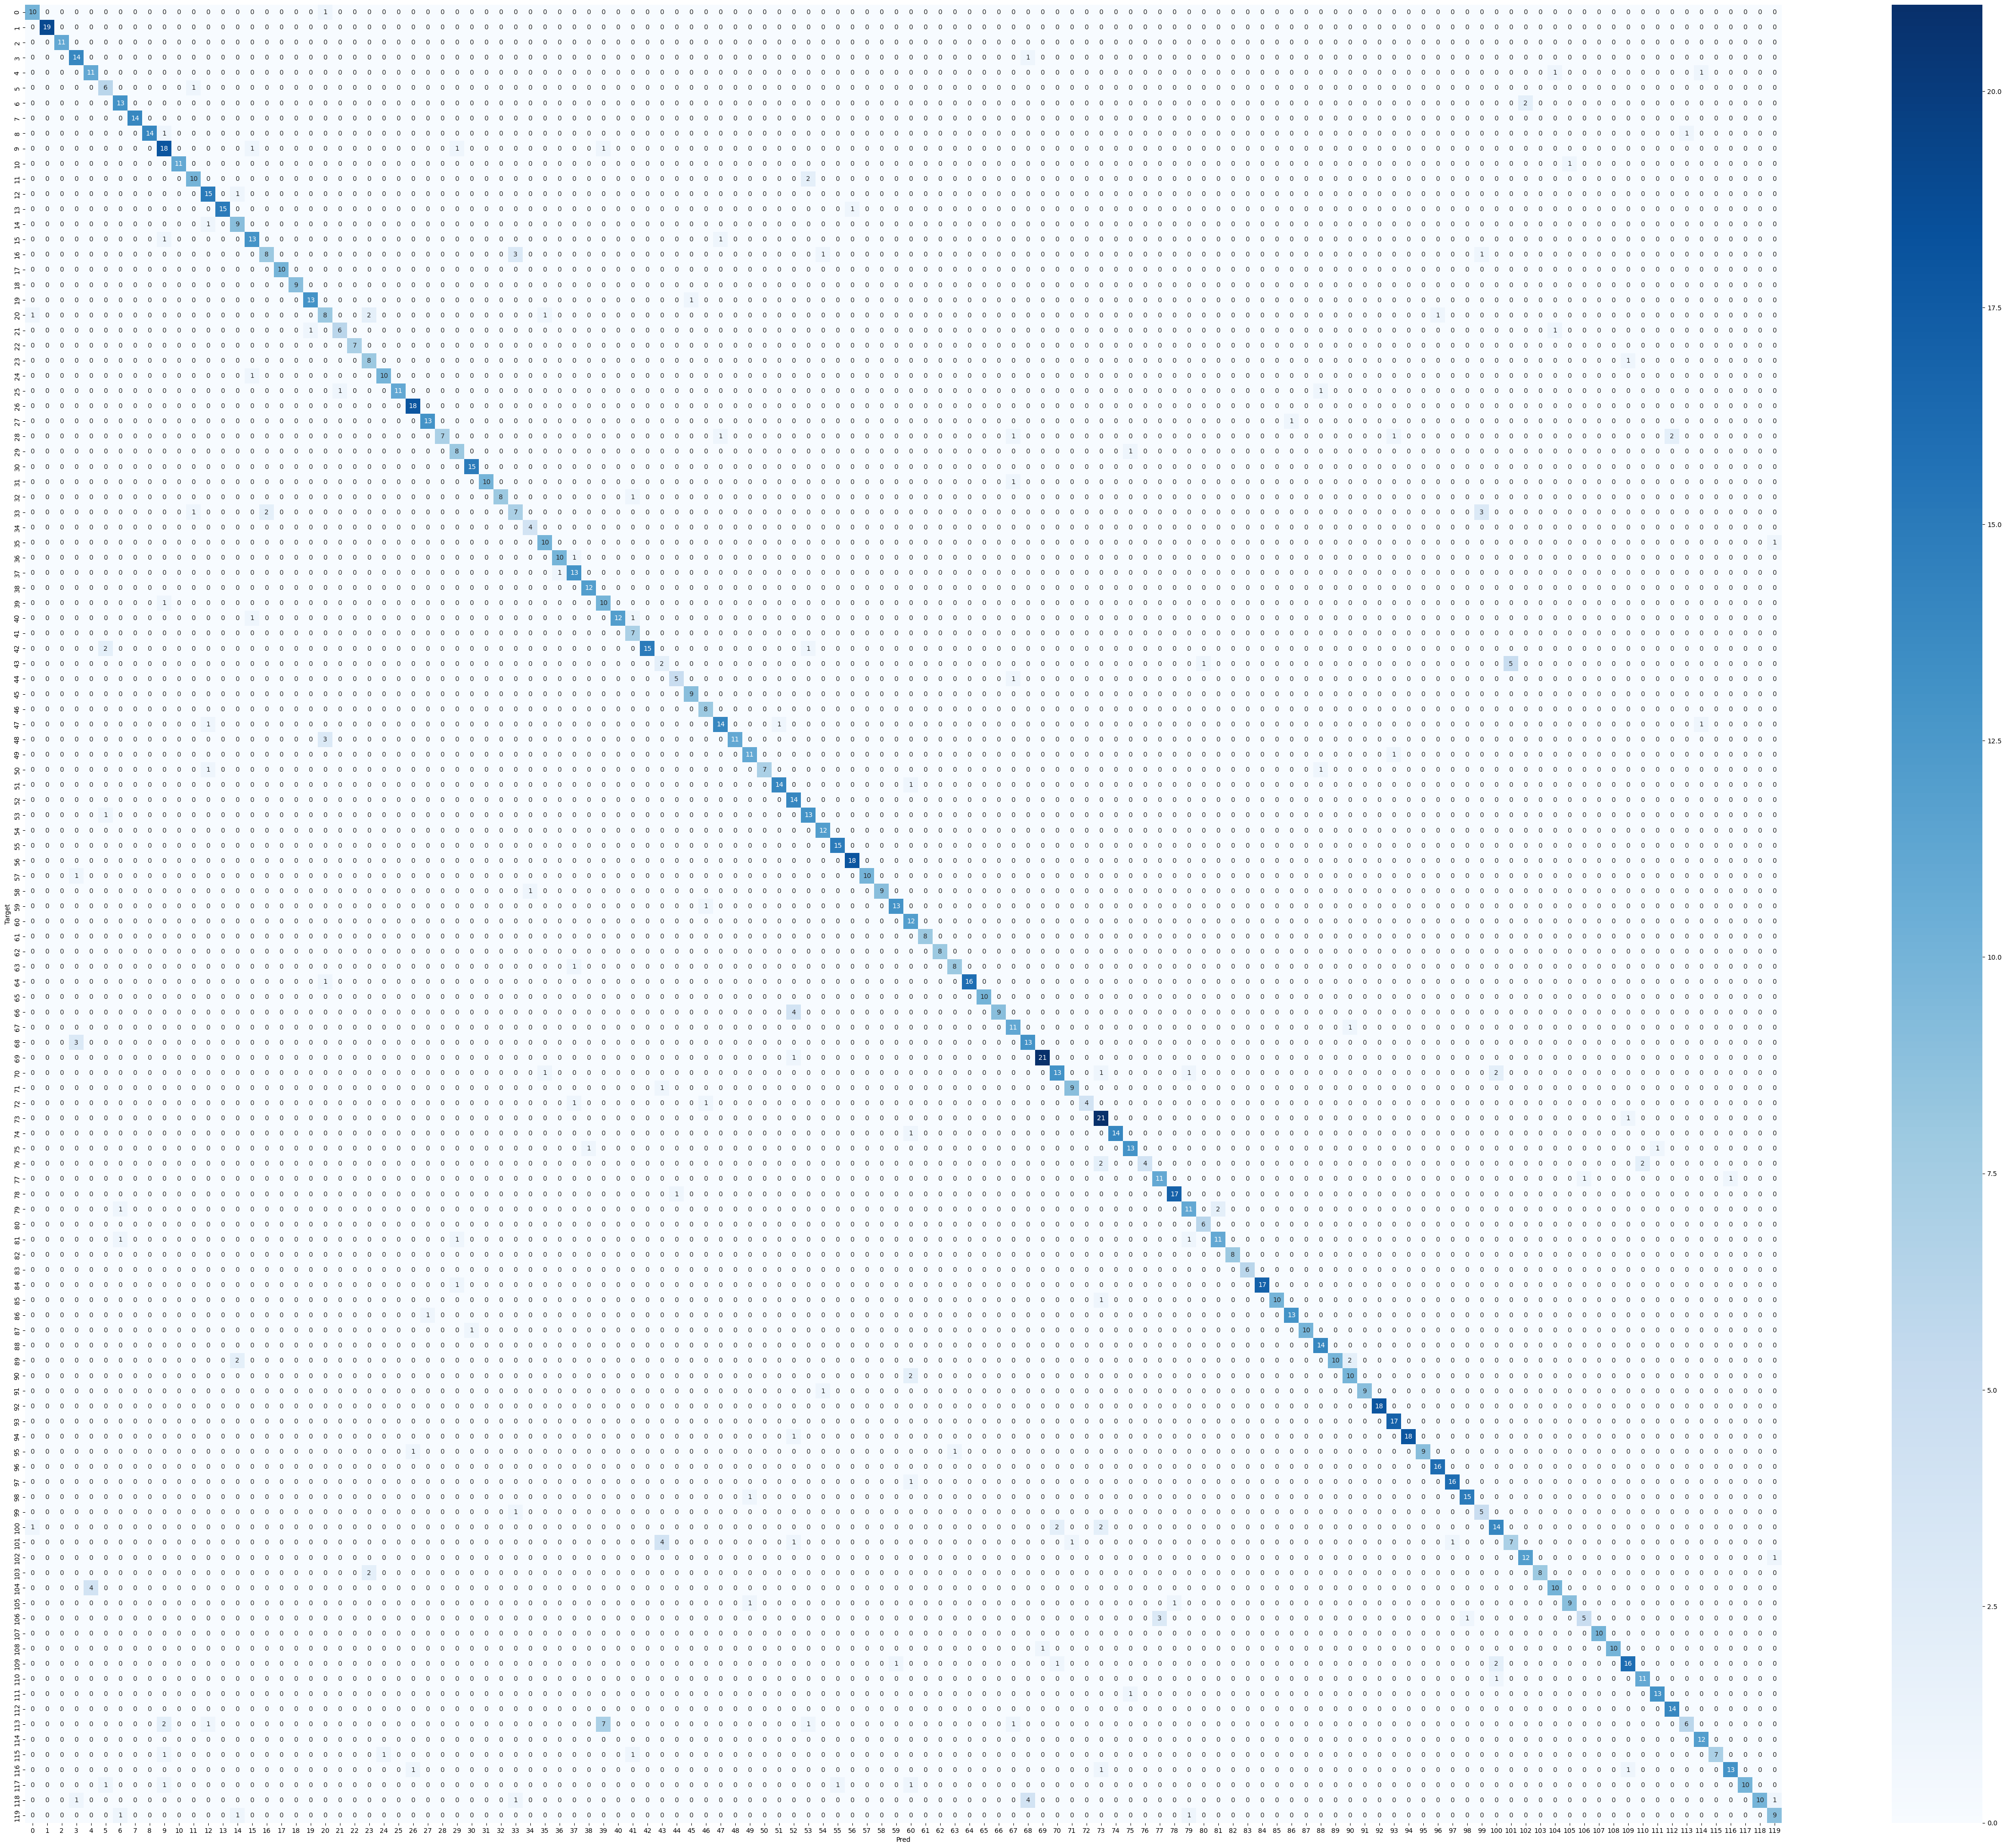


训练RBF核SVM...
RBF SVM准确率: 0.8650

RBF SVM分类报告:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        11
           3       0.78      0.93      0.85        15
           4       0.73      0.85      0.79        13
           5       0.71      0.71      0.71         7
           6       0.93      0.87      0.90        15
           7       0.93      0.93      0.93        14
           8       1.00      0.75      0.86        16
           9       0.73      0.90      0.81        21
          10       1.00      0.92      0.96        12
          11       0.91      0.83      0.87        12
          12       0.79      0.94      0.86        16
          13       1.00      0.94      0.97        16
          14       0.73      0.80      0.76        10
          15       0.93      0.87      0.90        15
          16       0.75      0.69 

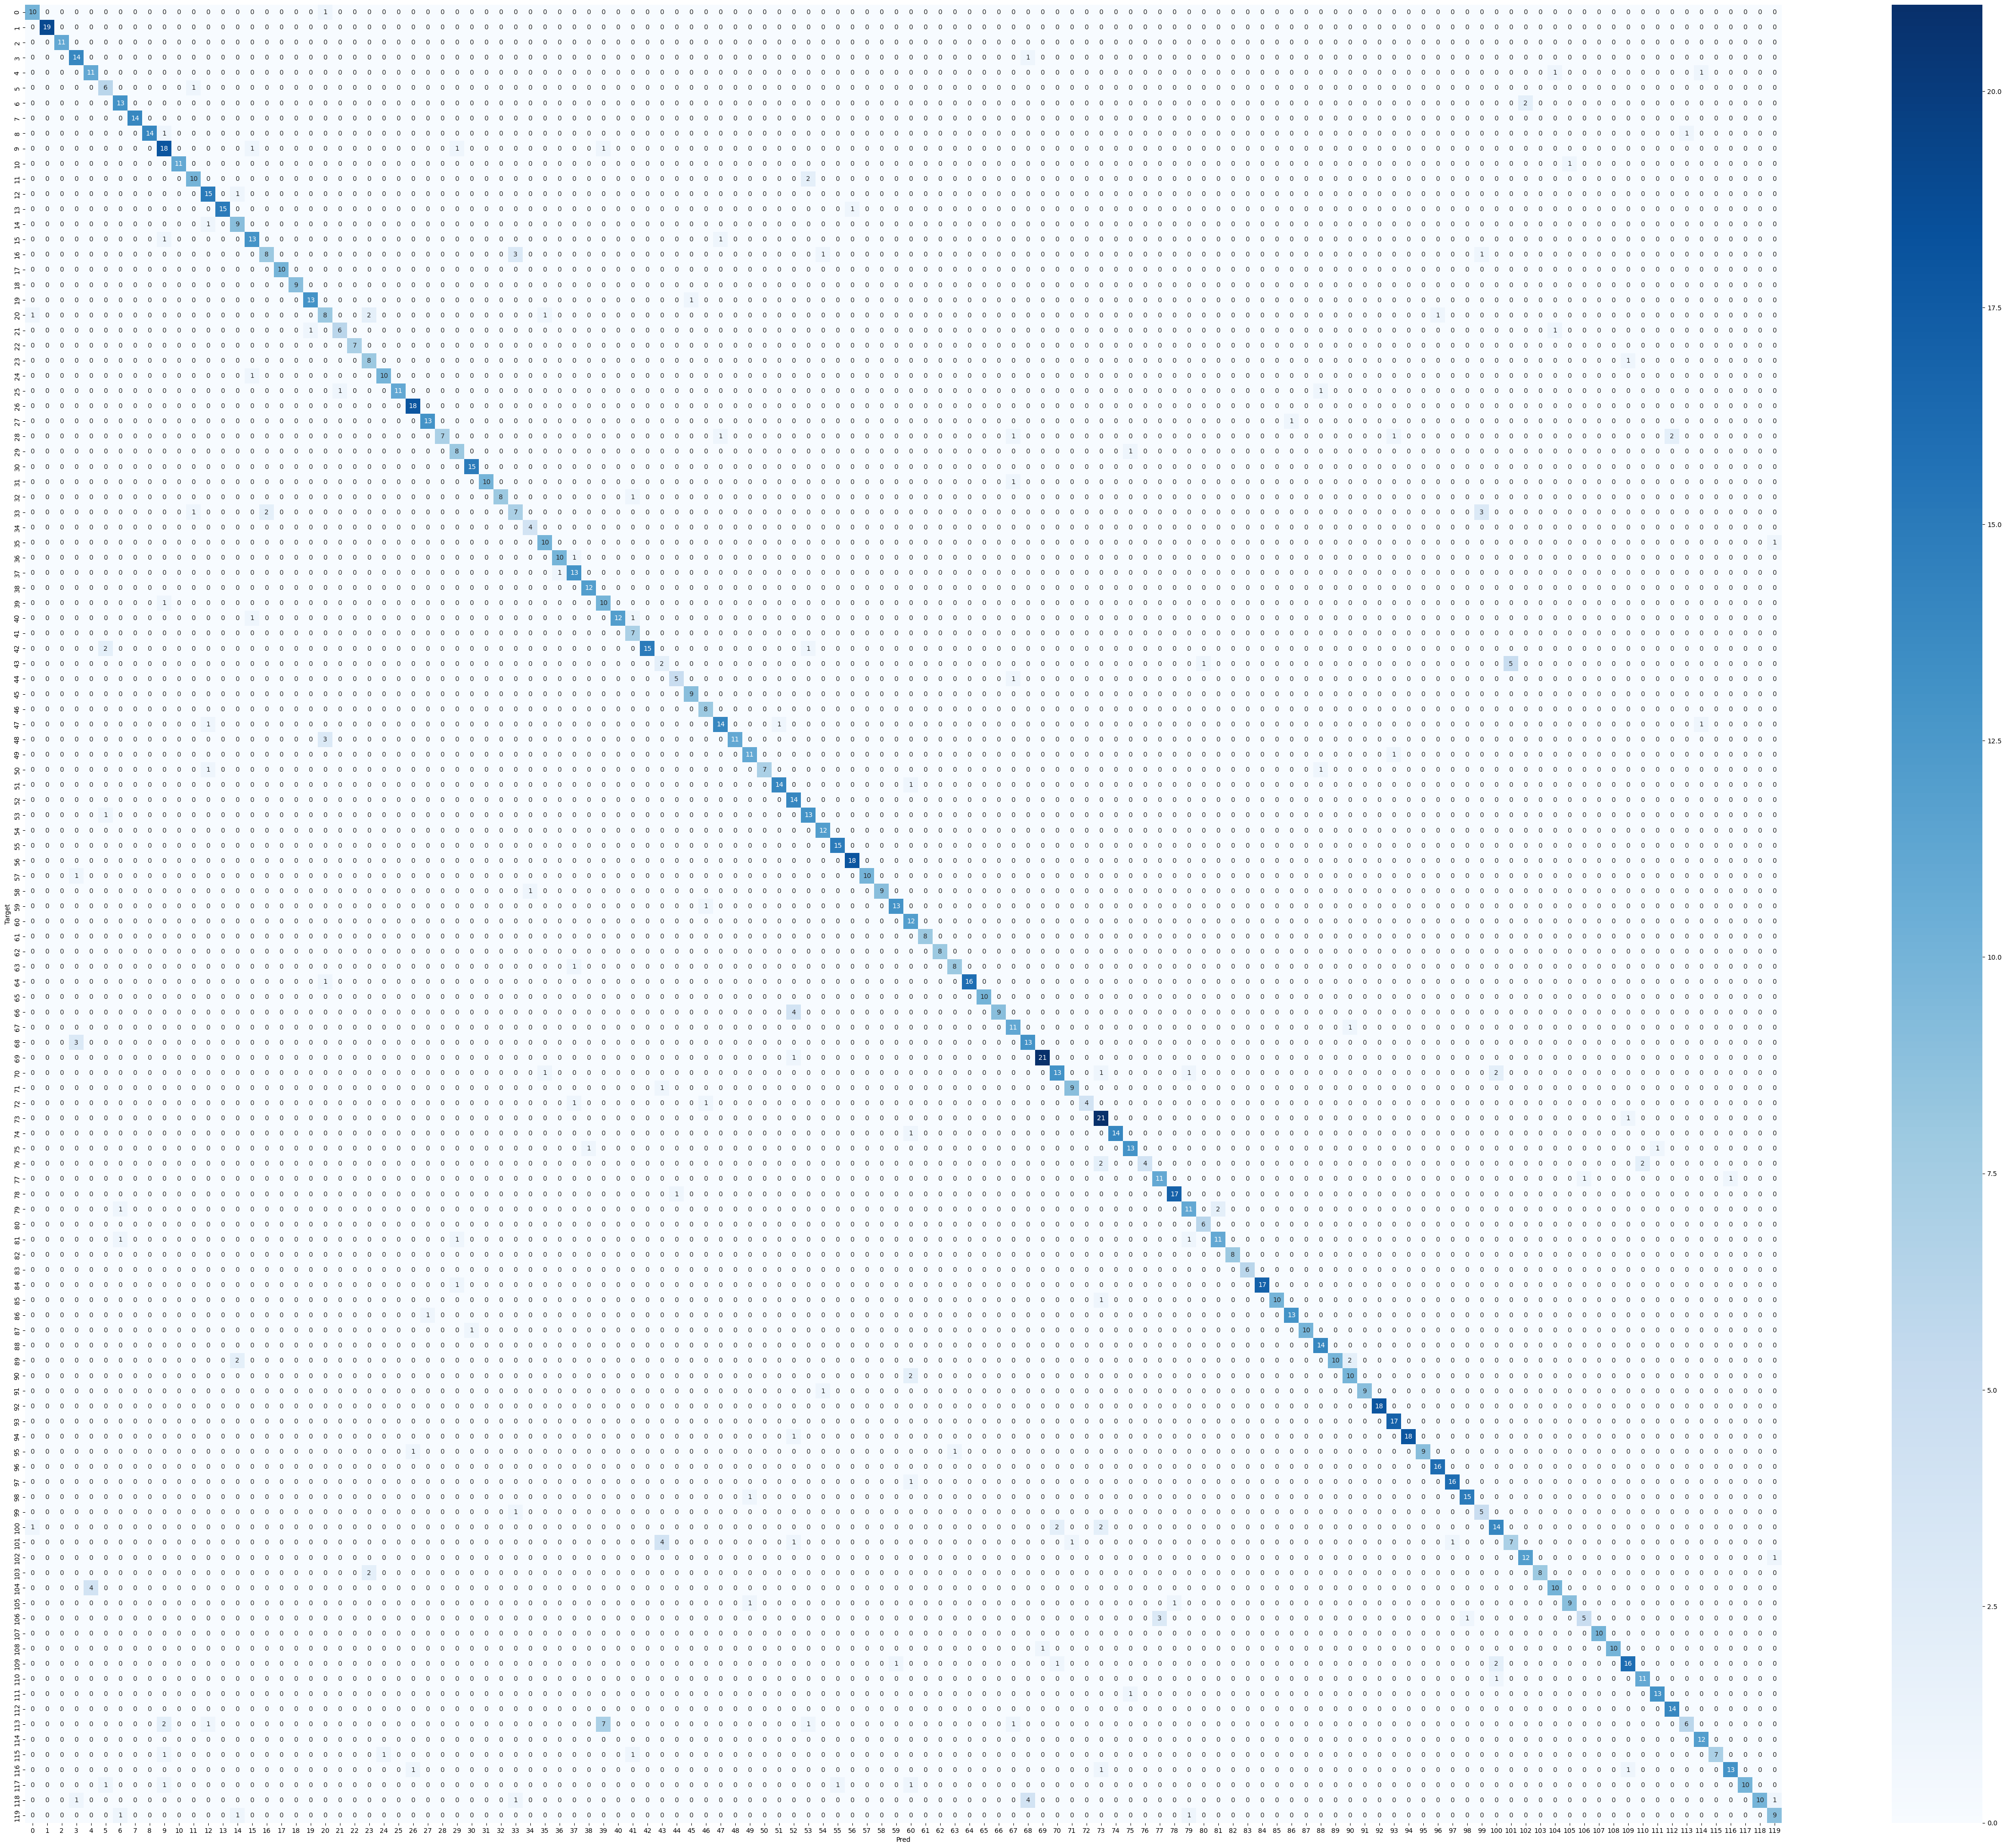

随机选取的类: [  1  12  14  22  23  27  28  33  38  45  47  53  65  66  75  78  84 101
 104 115]


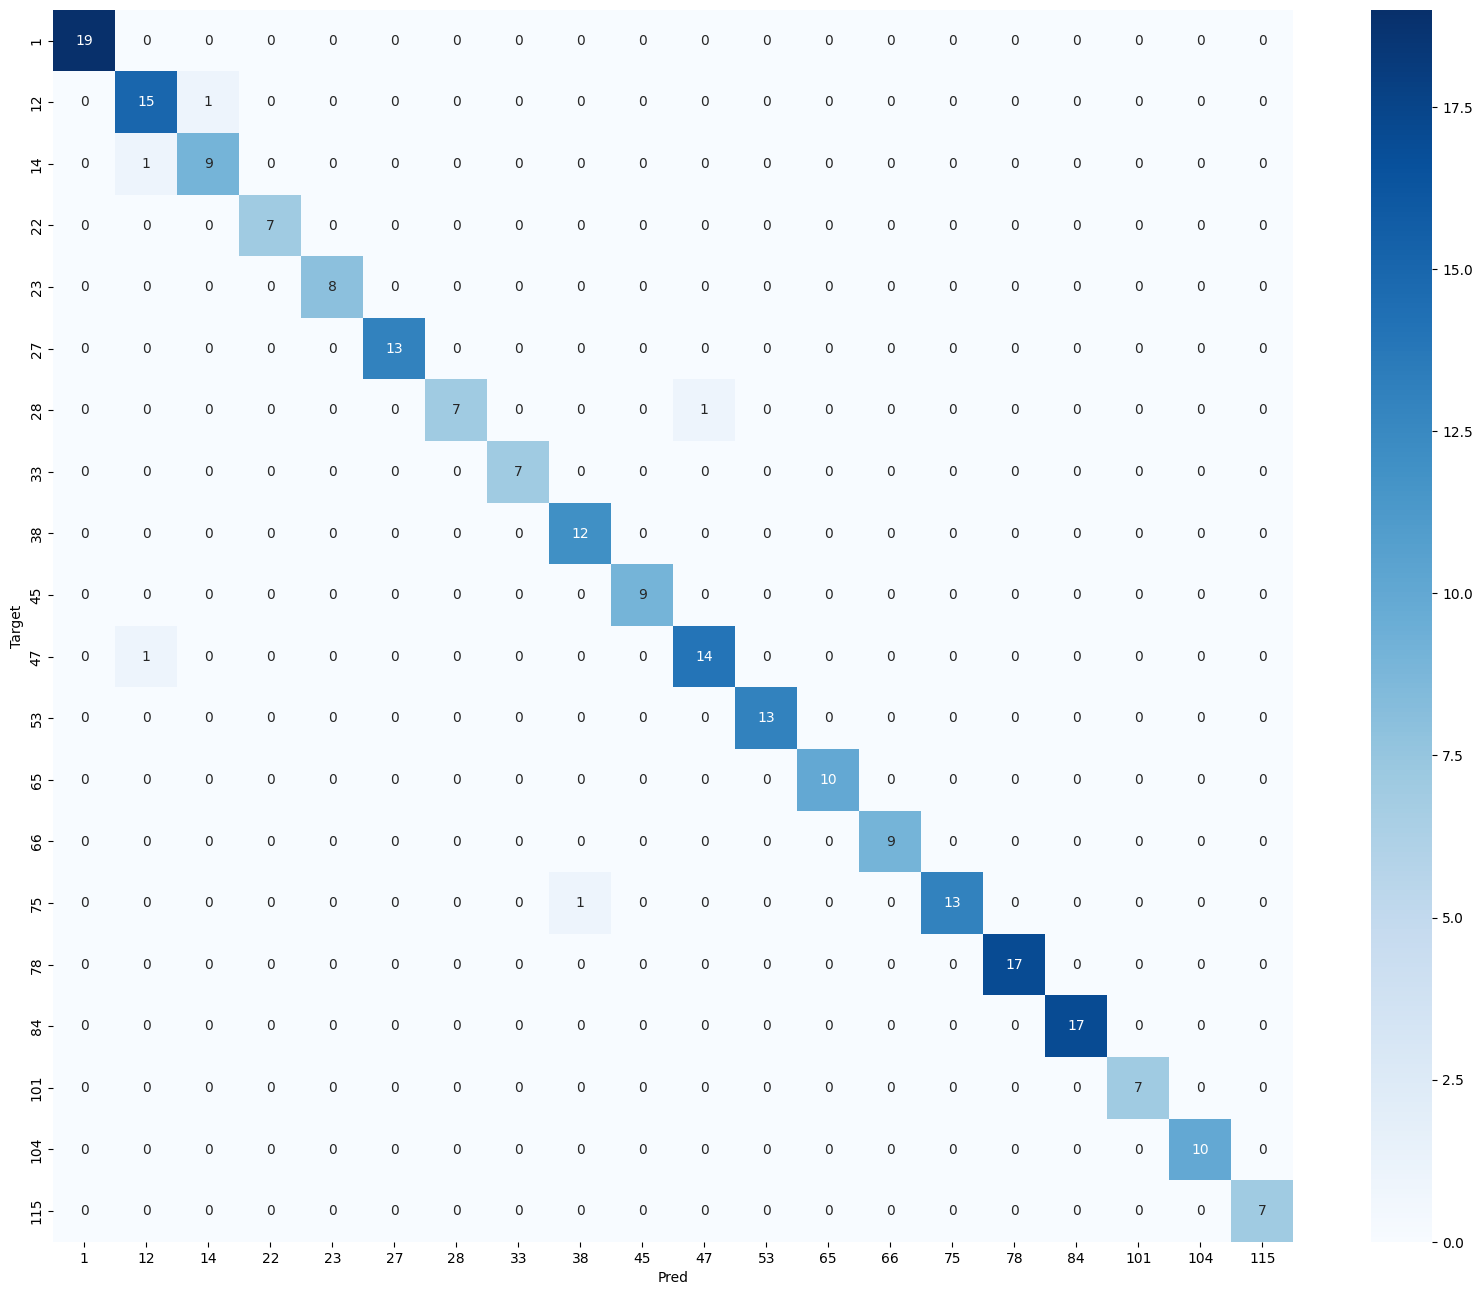


进行5折交叉验证...
线性SVM交叉验证准确率: 0.6781 (+/- 0.0355)
RBF SVM交叉验证准确率: 0.6743 (+/- 0.0420)

选择线性SVM作为最佳模型 (准确率: 0.8702)


In [17]:
# 训练SVM分类器
from utils.train import train_svm_on_features
best_svm, best_accuracy, kernel_type = train_svm_on_features(
    features_train, labels_train, features_valid, labels_valid, "SENet101"
)

True


Fusion Ensemble Inference:   0%|          | 0/128 [00:00<?, ?it/s]

Fusion Ensemble Inference: 100%|██████████| 128/128 [00:50<00:00,  2.52it/s]


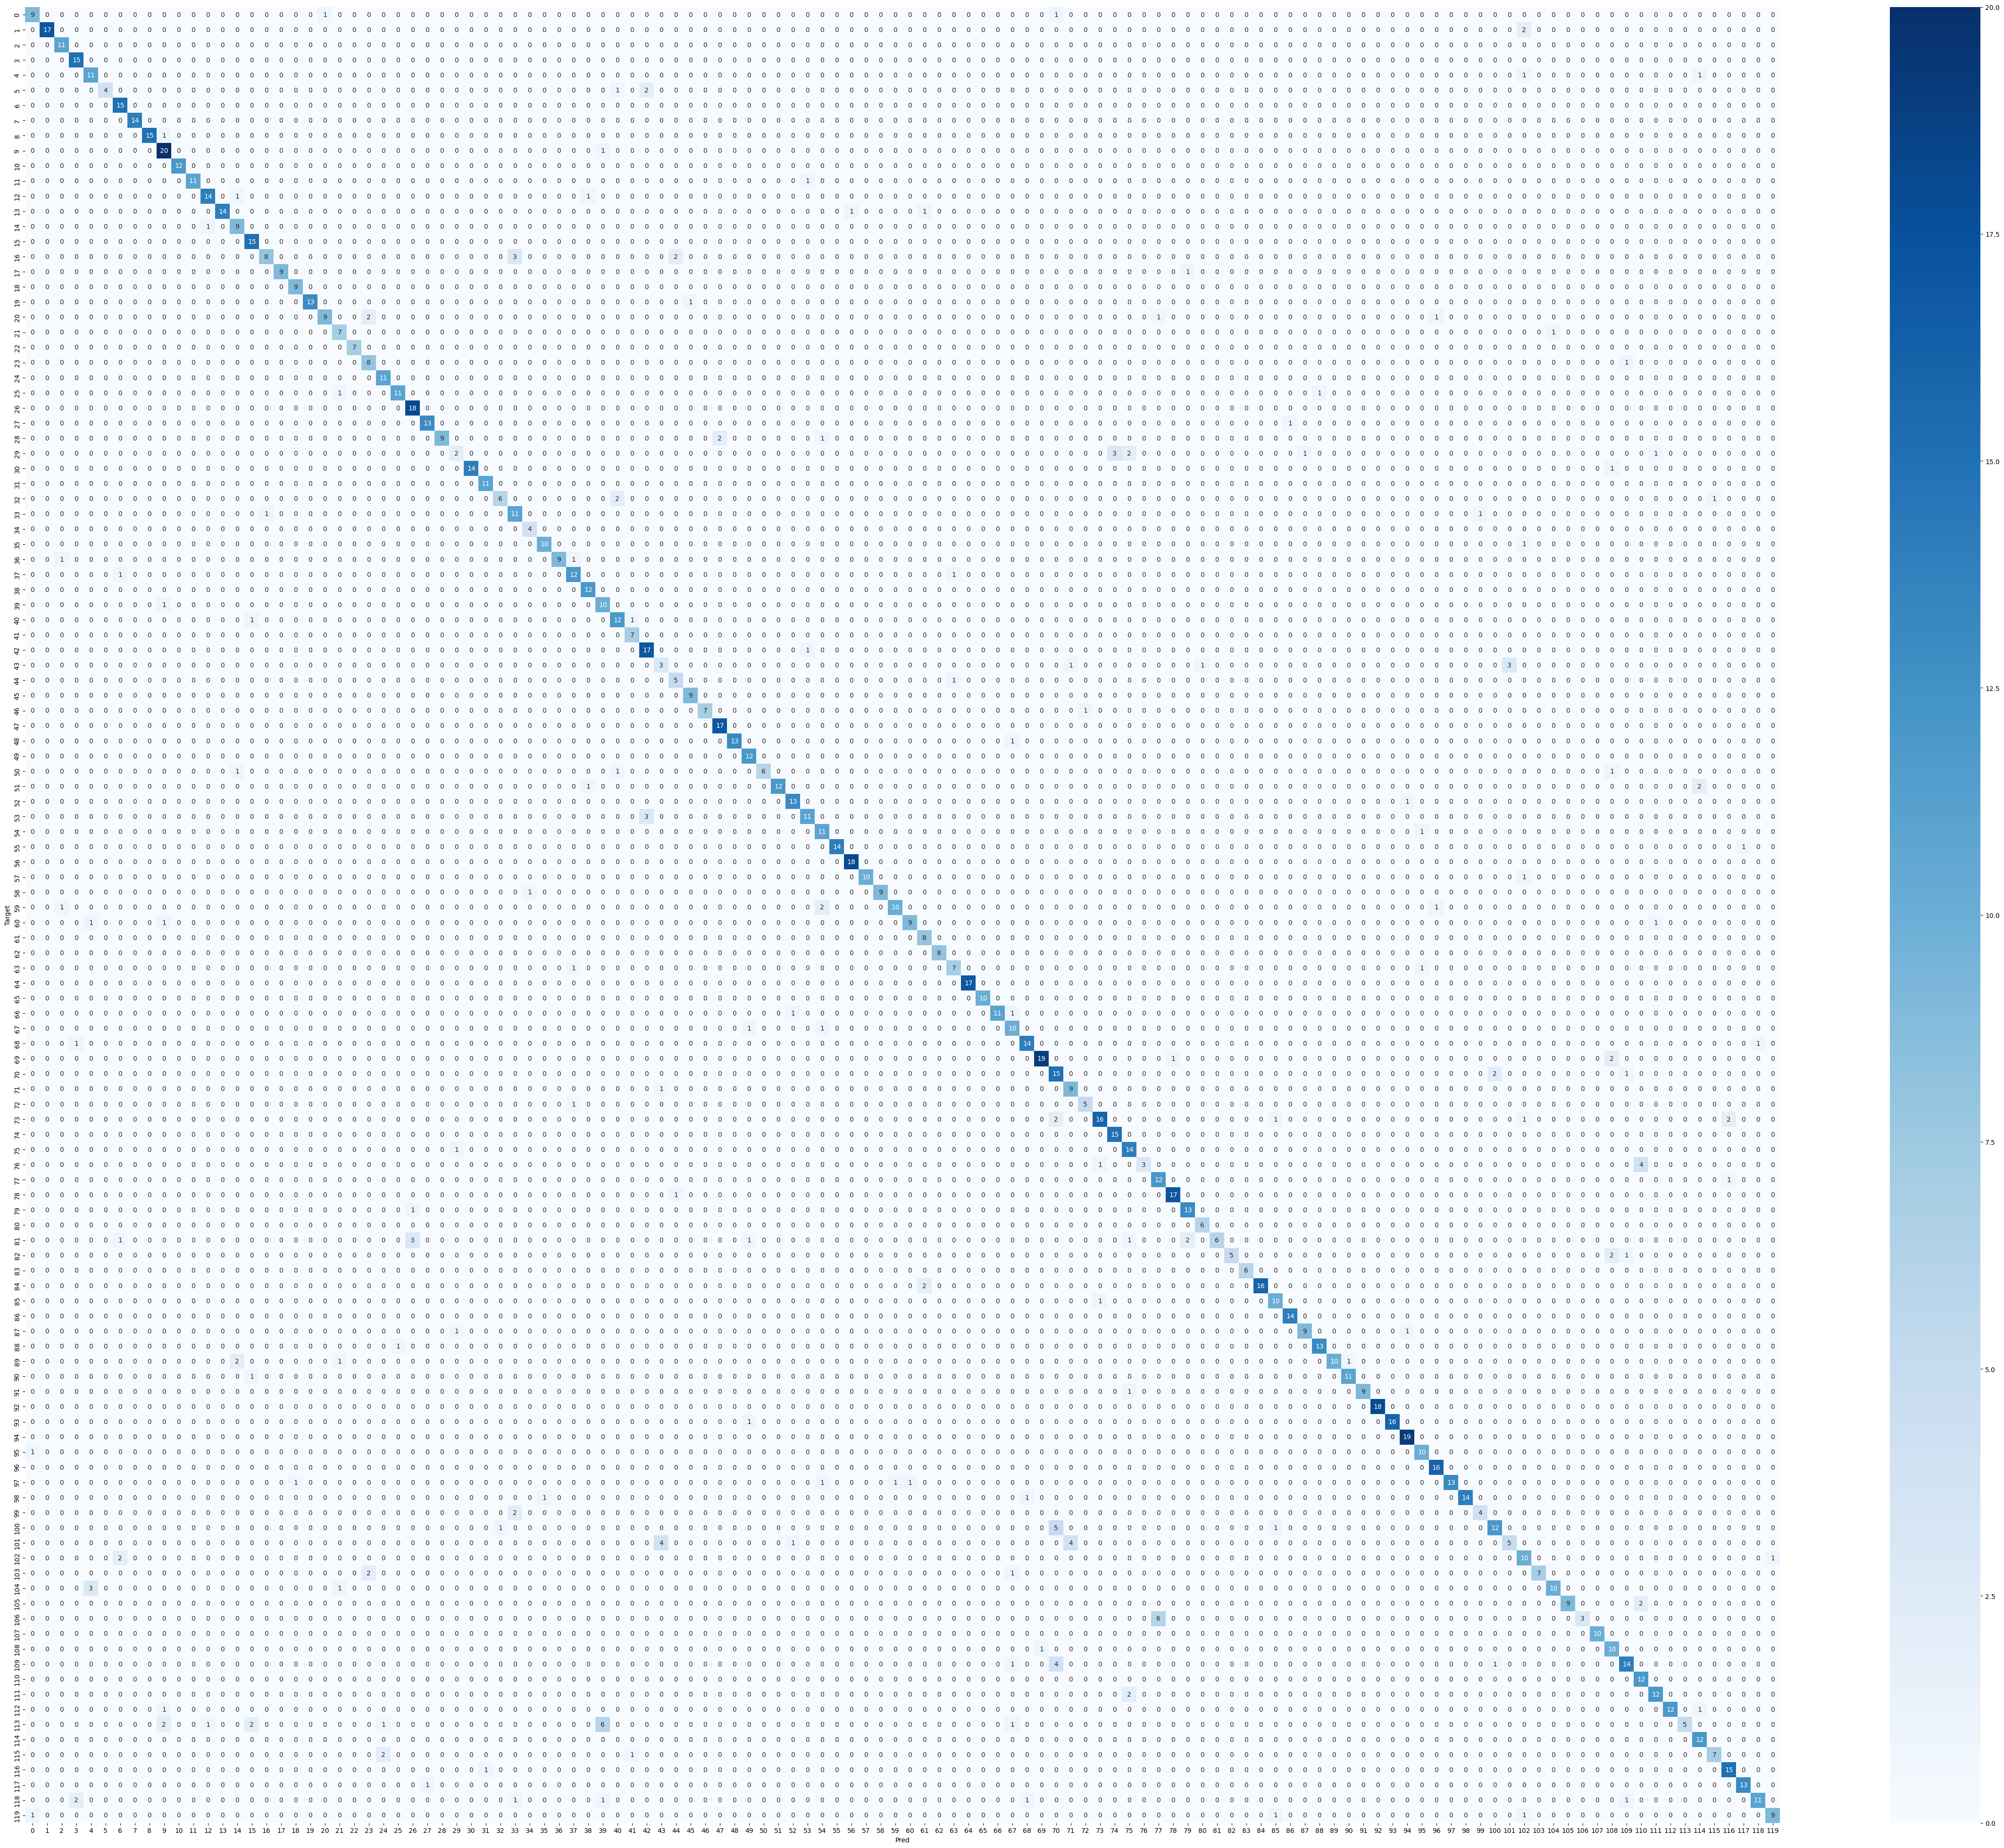

随机选取的类: [  1  12  14  22  23  27  28  33  38  45  47  53  65  66  75  78  84 101
 104 115]


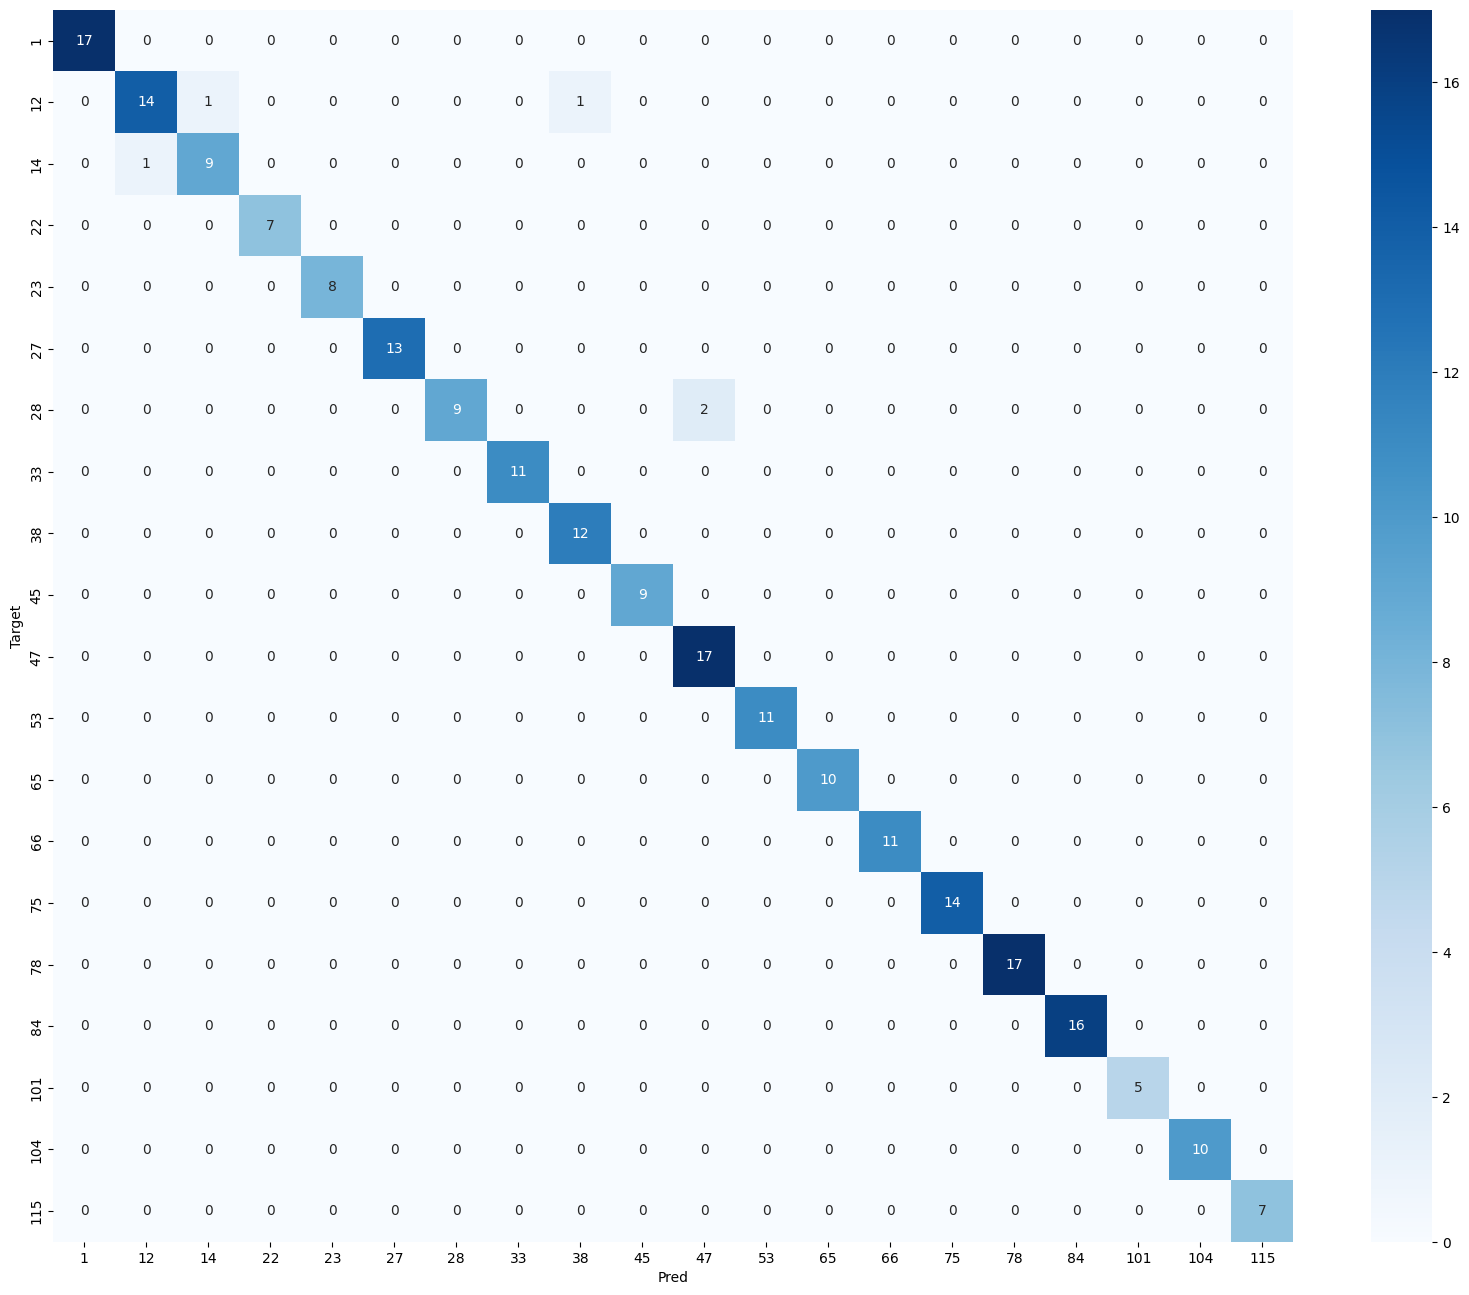

Soft Voting Ensemble ACC: 0.8545335942596216


In [16]:
import torch
import torch.nn.functional as F
from utils.ensemble_learning import EnsembleSoftVoting
from utils.evaluate import evaluate_feature_fusion

ensemble_model = EnsembleSoftVoting(resnet101, senet101, weight1=0.6, weight2=0.4)
ensemble_model.eval()
print(use_cuda)
acc, preds, targets = evaluate_feature_fusion(
    ensemble_model,
    dataloaders['valid'],
    use_cuda=use_cuda,
    save_path=('./result/soft_vote_cm_120.png','./result/soft_vote_cm_rnd20.png')
)
print("Soft Voting Ensemble ACC:", acc)

Fusion Ensemble Inference:   0%|          | 0/128 [00:00<?, ?it/s]

Fusion Ensemble Inference: 100%|██████████| 128/128 [00:51<00:00,  2.49it/s]


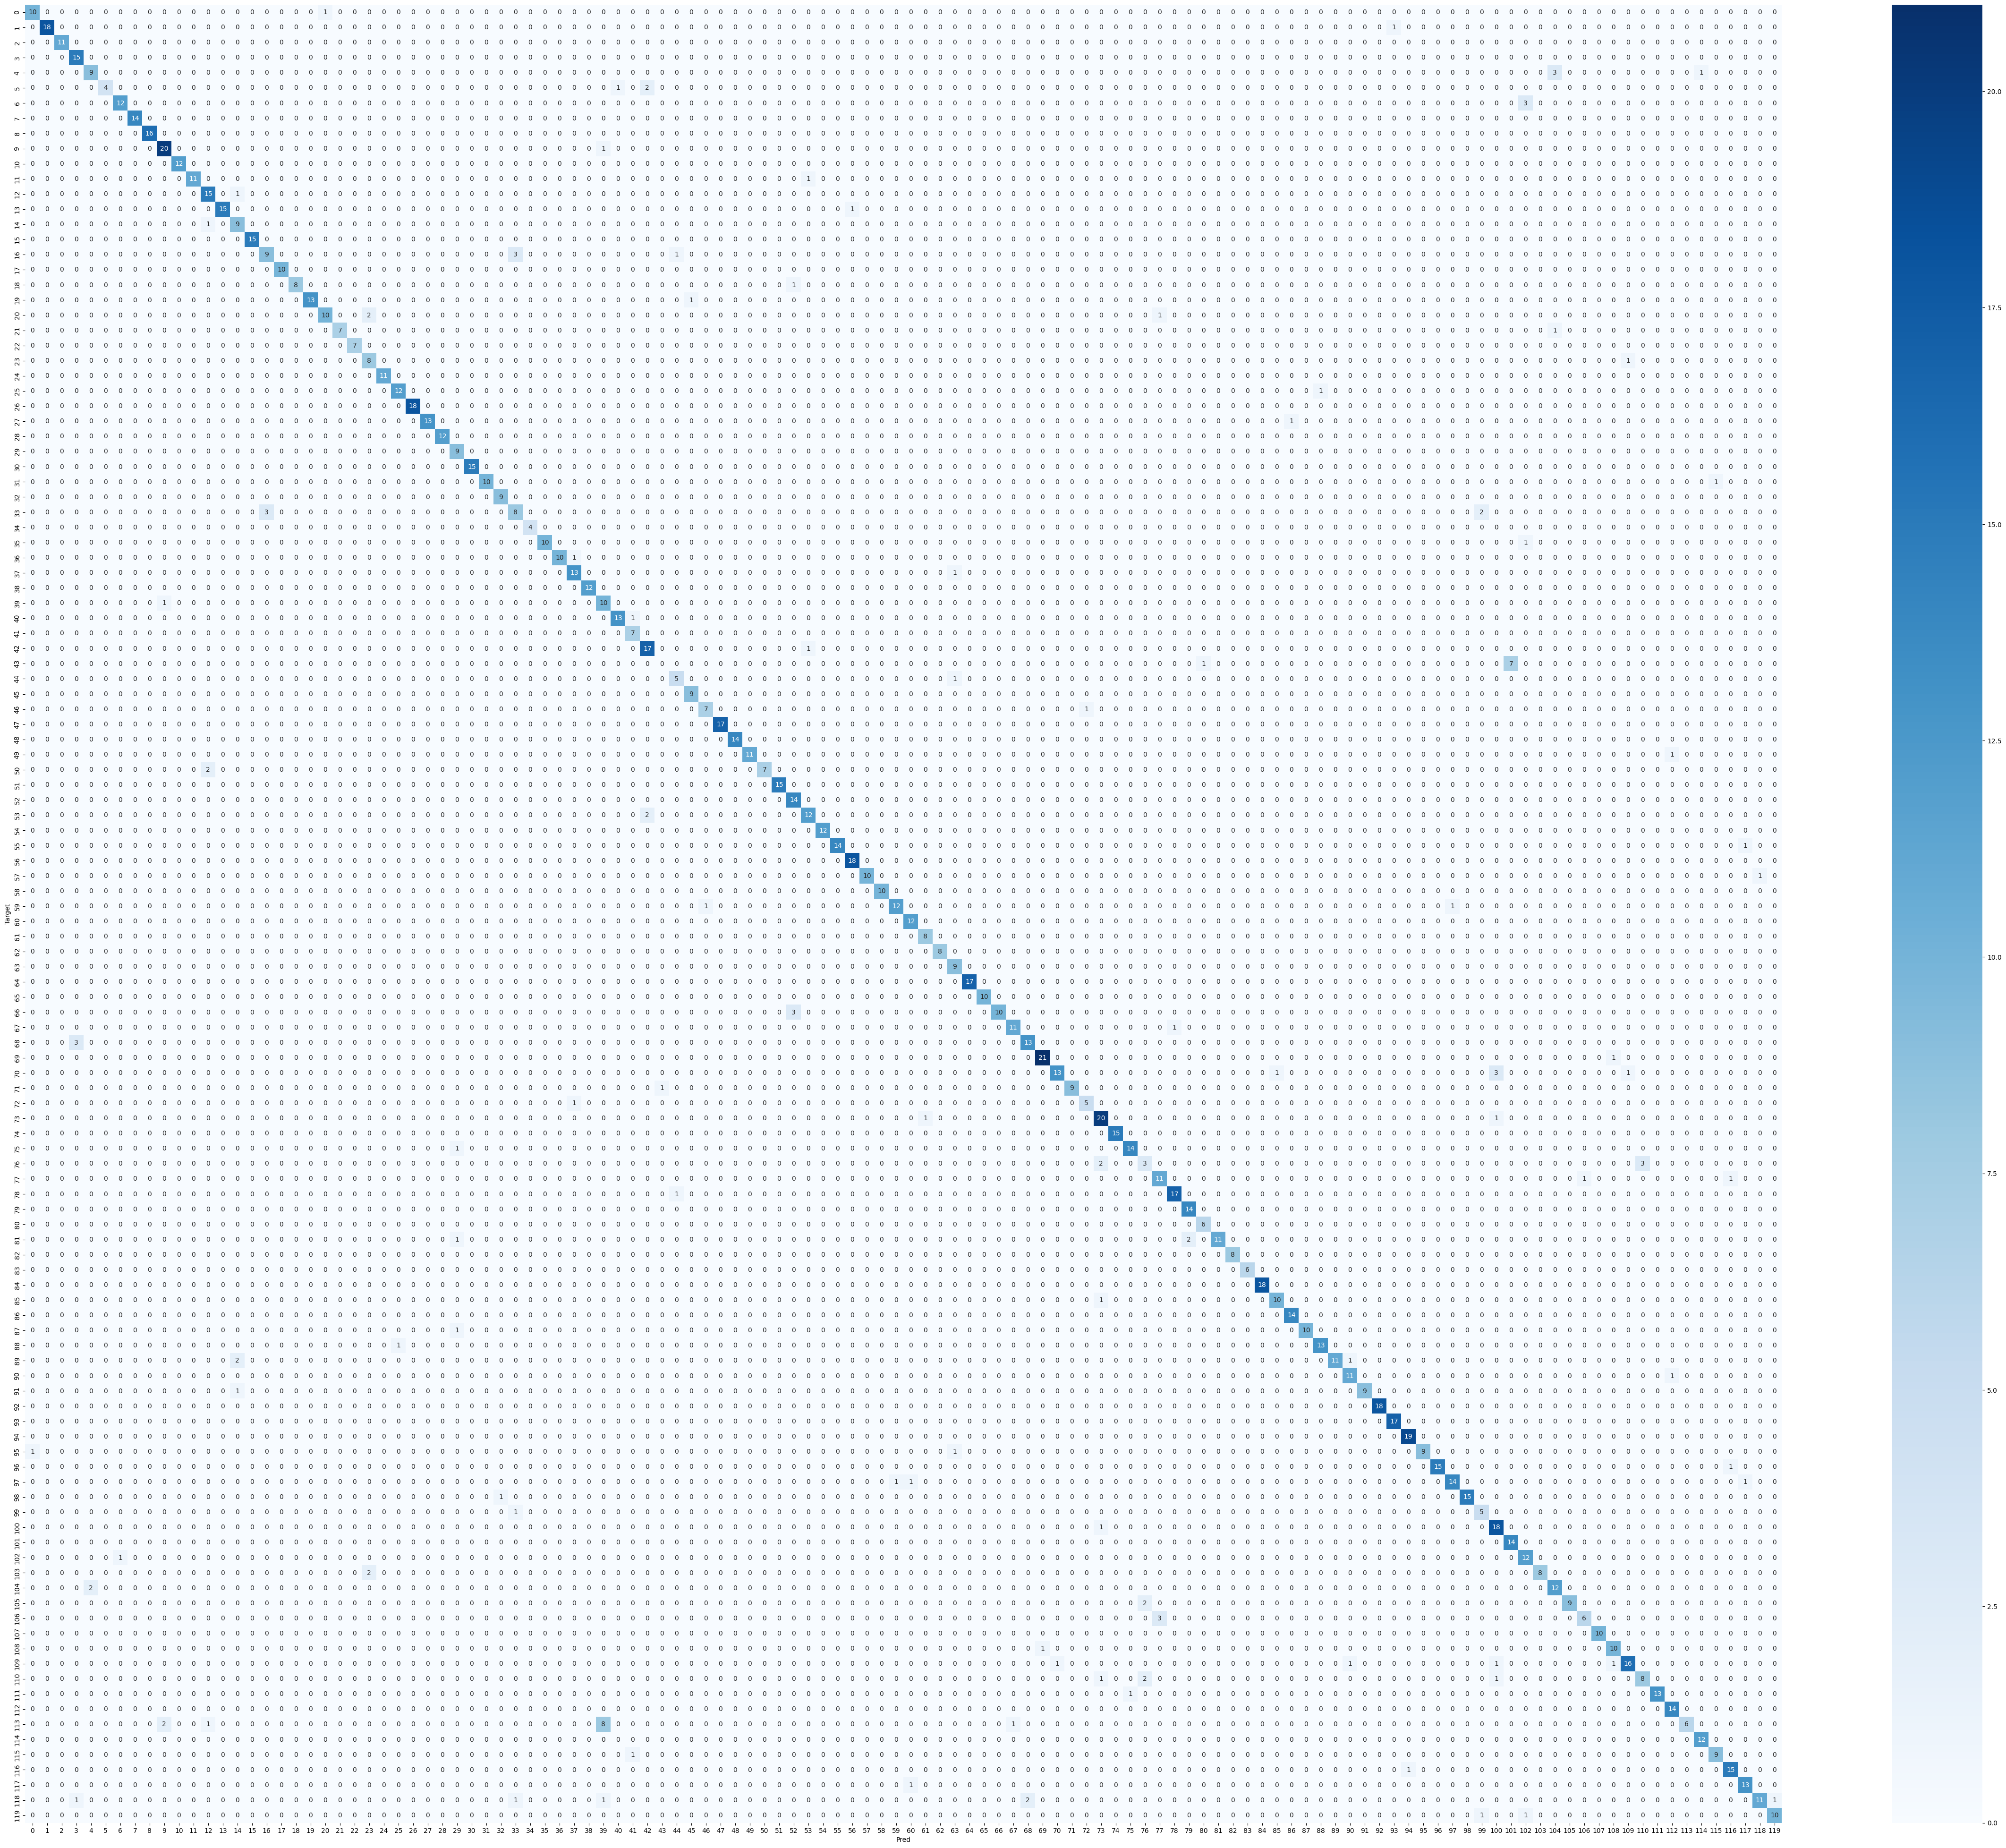

随机选取的类: [ 19  20  21  23  33  37  43  52  57  62  63  67  69  71  79  87  96 100
 110 116]


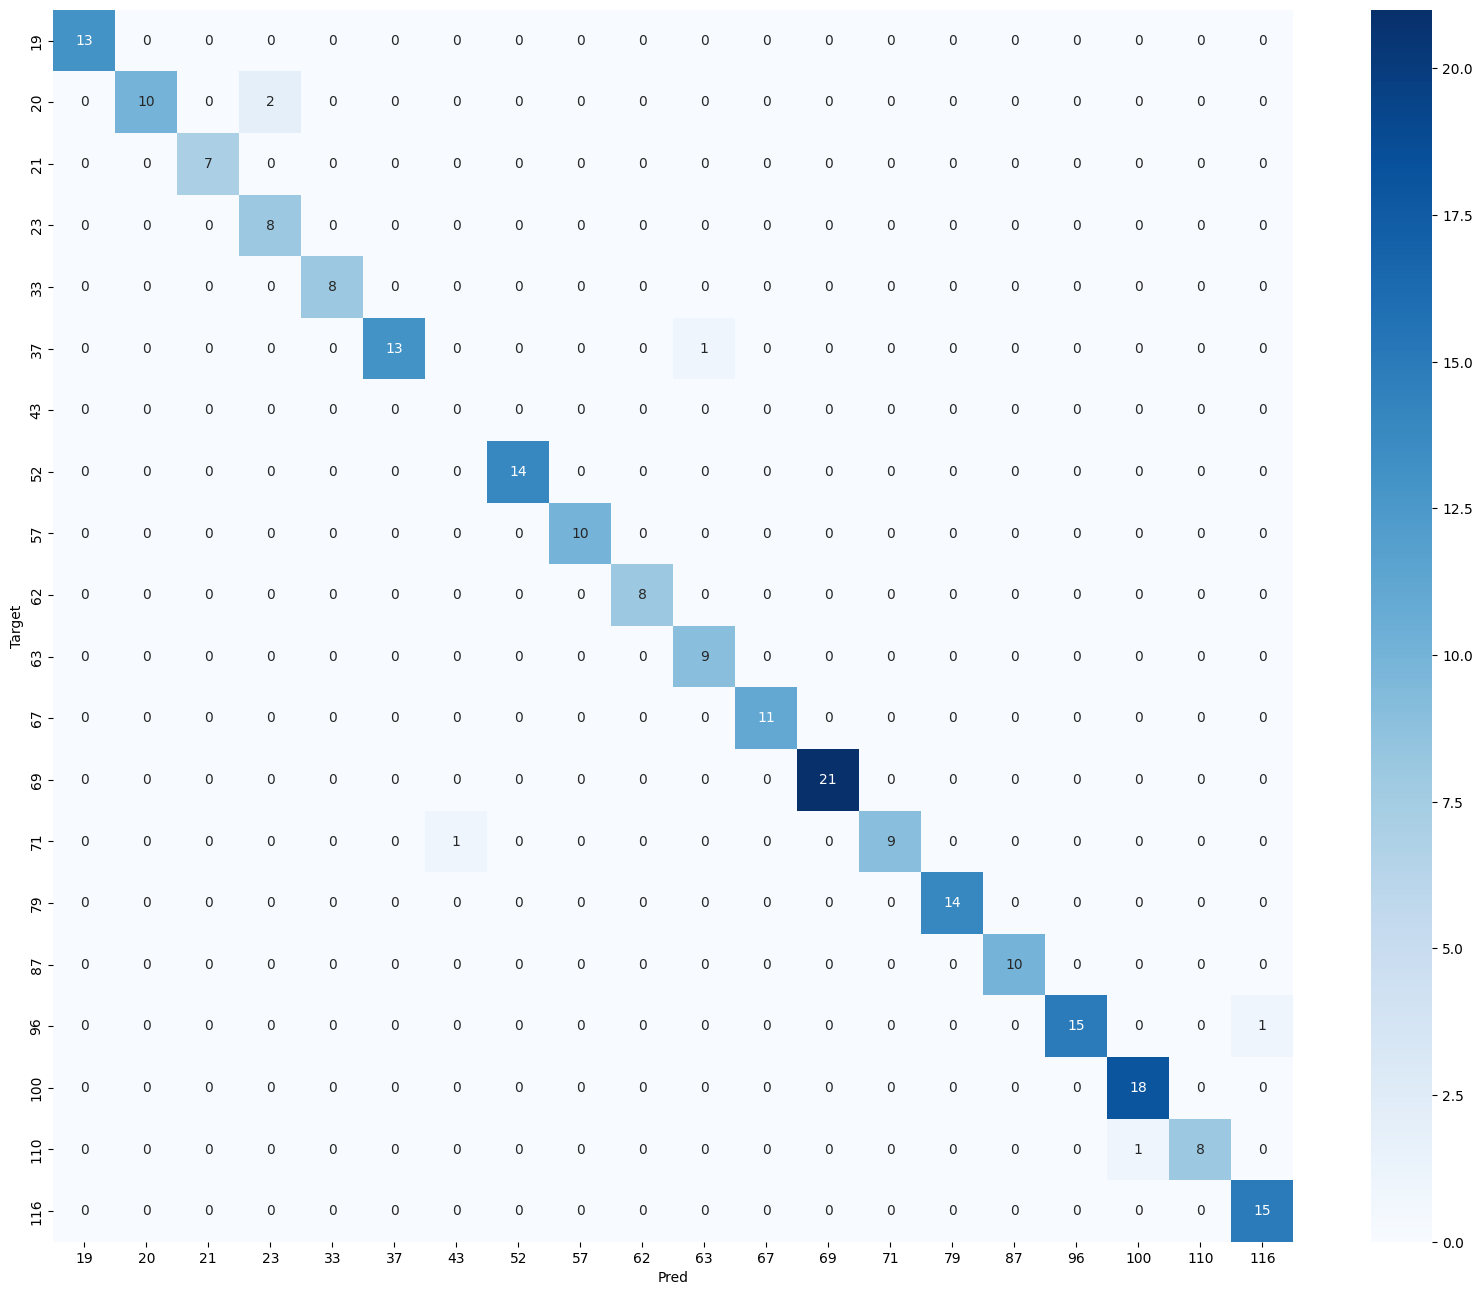

Fusion Ensemble ACC: 0.9021526418786693


In [17]:
from utils.evaluate import evaluate_feature_fusion
from utils.ensemble_learning import FeatureFusionEnsemble
ensemble_model.eval()
acc, preds, targets = evaluate_feature_fusion(
    fusion_model,
    dataloaders['valid'],
    use_cuda,
    save_path=('./result/fusion_cm_120.png','./result/fusion_cm_rnd20.png')
)
print("Fusion Ensemble ACC:", acc)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from utils.train import train_kd
import torch.nn as nn

teacher = fusion_model 
student = alexnet  

for p in teacher.parameters():
    p.requires_grad = False  # 冻结教师模型
teacher.eval()
optimizer = torch.optim.Adam(student.parameters(), lr=1e-4)
train_accuracies_list=[]
valid_accuracies_list=[]
train_losses_list=[]
valid_losses_list=[]    
for T in [4,15]:
    print(f"Training with Temperature: {T}")
    _,train_losses, valid_losses,train_accuracies,valid_accuracies=train_kd(student, teacher, dataloaders, optimizer, use_cuda,T = T, n_epochs=25)
    train_accuracies_list.append(train_accuracies)
    valid_accuracies_list.append(valid_accuracies)
    train_losses_list.append(train_losses)  
    valid_losses_list.append(valid_losses)
models_name=[f'TS_alexnet_T={T}' for T in [4,15]]
print(models_name)
teacher = fusion_model 
student = efficientnet_b0 
optimizer = torch.optim.Adam(student.parameters(), lr=1e-4)  
for T in [4,8,10]:
    print(f"Training with Temperature: {T}")
    _,train_losses, valid_losses,train_accuracies,valid_accuracies=train_kd(student, teacher, dataloaders, optimizer, use_cuda,T = T, n_epochs=25)
    train_accuracies_list.append(train_accuracies)
    valid_accuracies_list.append(valid_accuracies)
    train_losses_list.append(train_losses)  
    valid_losses_list.append(valid_losses)
    models_name.append(f'TS_efficientnet_T_{T}')

Training with Temperature: 4
Model already exists, loading from ./model_weight/TS_alexnet_epoch25_T4.pt
Model loaded successfully.
Training with Temperature: 15
Model already exists, loading from ./model_weight/TS_alexnet_epoch25_T15.pt
Model loaded successfully.
['TS_alexnet_T=4', 'TS_alexnet_T=15']
Training with Temperature: 4
Model already exists, loading from ./model_weight/TS_efficientnet_epoch25_T4.pt
Model loaded successfully.
Training with Temperature: 8
Model already exists, loading from ./model_weight/TS_efficientnet_epoch25_T8.pt
Model loaded successfully.
Training with Temperature: 10
Epoch: 0 	Batch: 1 	Training Loss: 2.574875
Epoch: 0 	Batch: 101 	Training Loss: 2.181883
Epoch: 0 	Batch: 201 	Training Loss: 2.158129
Epoch: 0 	Batch: 301 	Training Loss: 2.166523
Epoch: 0 	Batch: 401 	Training Loss: 2.153427
Epoch: 0 	Batch: 501 	Training Loss: 2.159248
Epoch: 0 	Batch: 601 	Training Loss: 2.158936
Epoch: 0 	Batch: 701 	Training Loss: 2.158501
Epoch 0: Train Loss = 2.1548, 

4


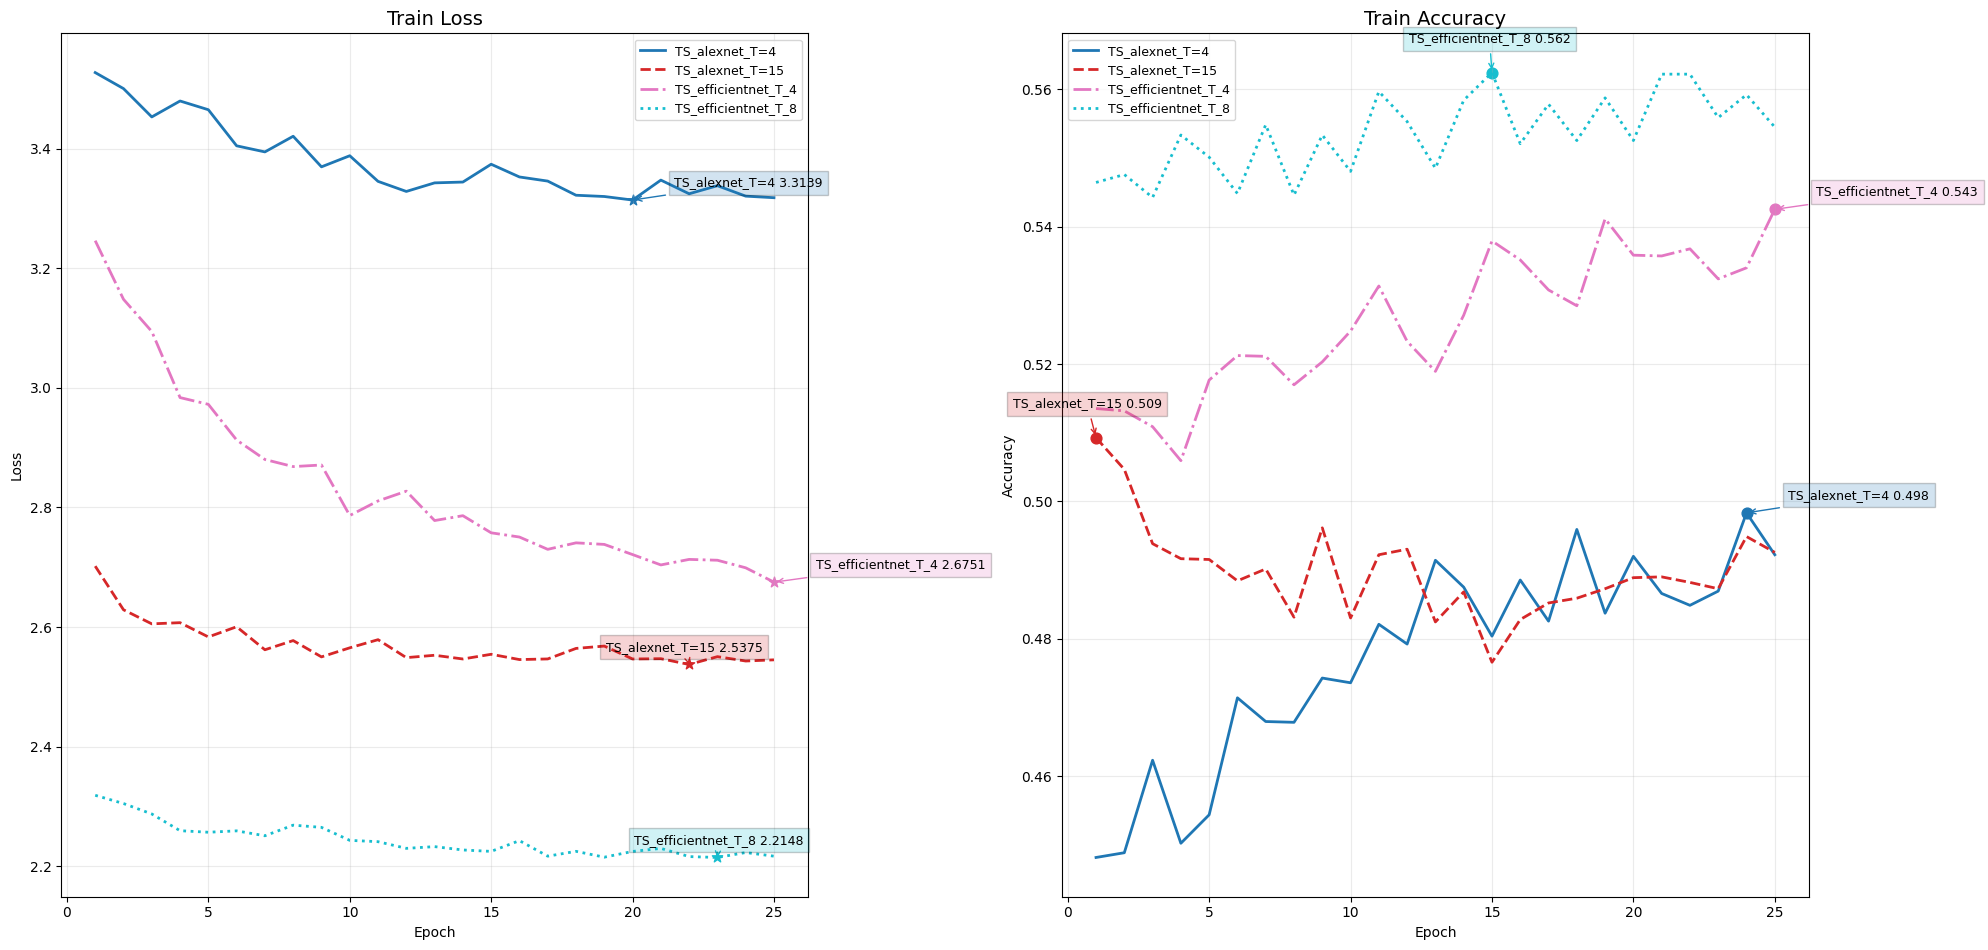

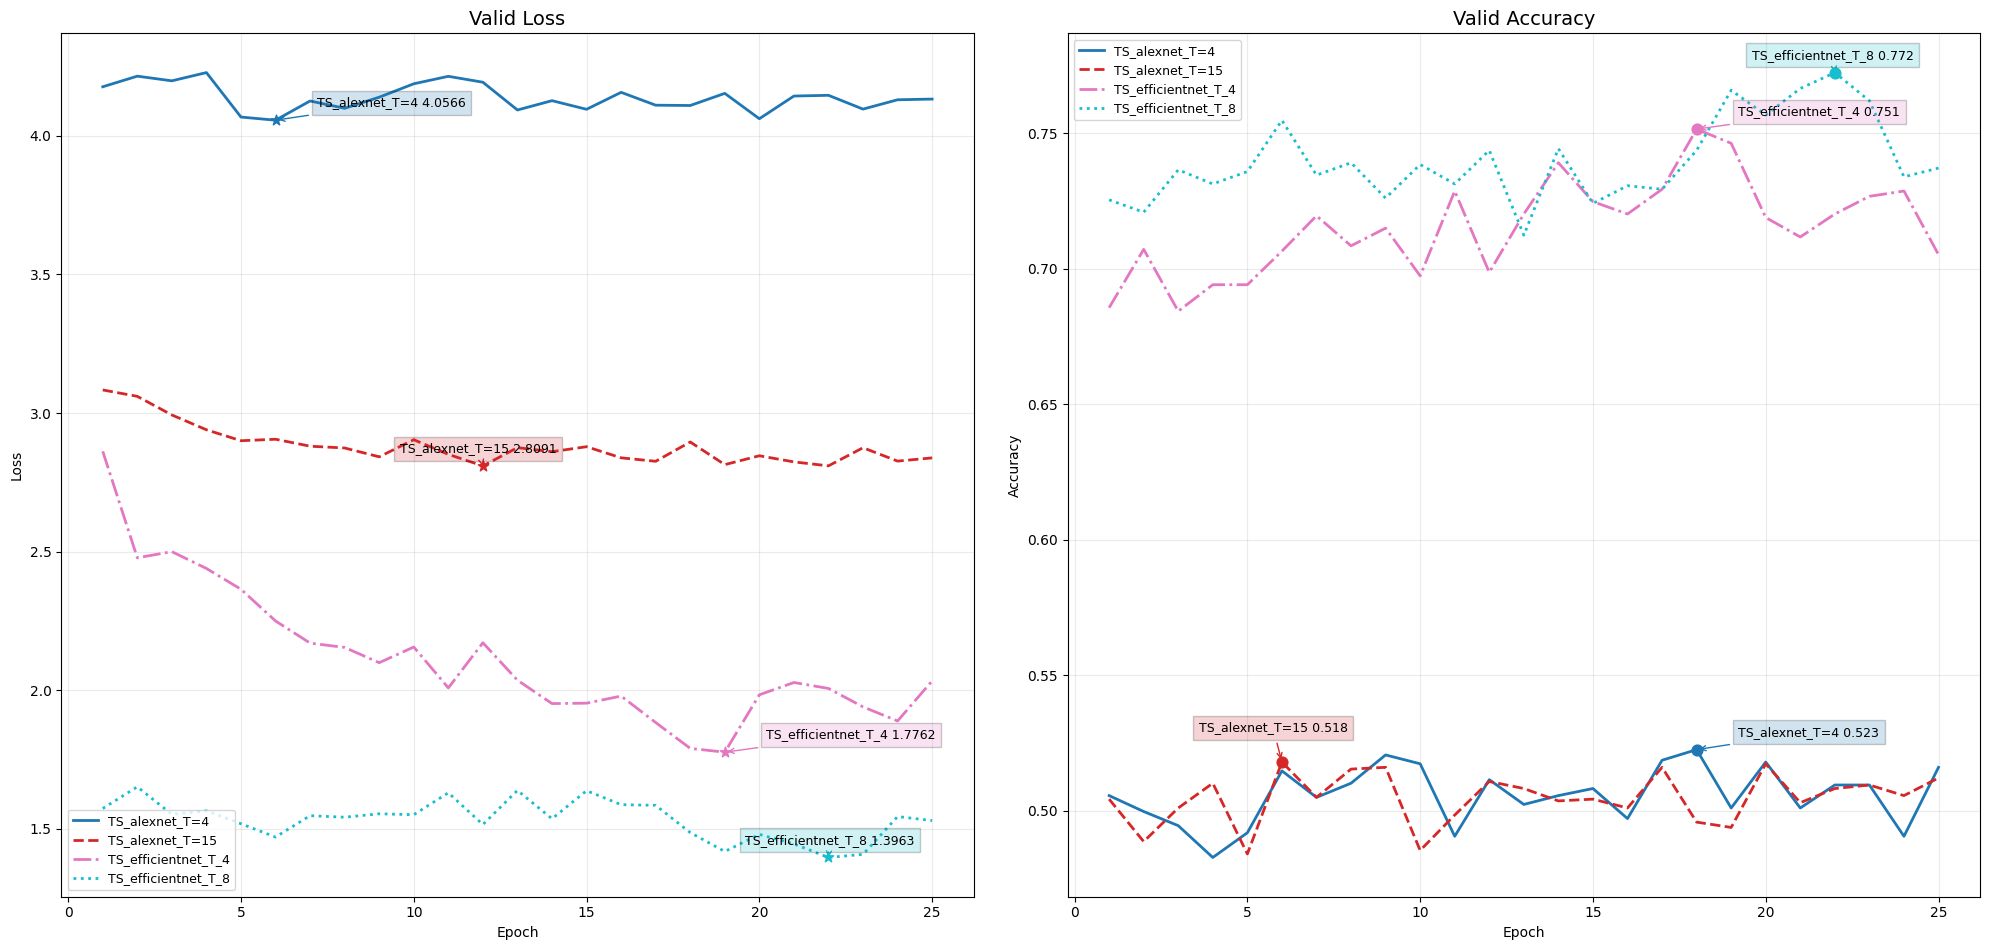

In [ ]:
with open("./log/train_loss/efficientnet_epoch25.log","r") as f:
        train_losses_list.extend([float(line.strip()) for line in f])
with open("./log/valid_loss/efficientnet_epoch25.log","r") as f:
        valid_losses_list.extend([float(line.strip()) for line in f])
with open("./log/train_accuracy/efficientnet_epoch25.log","r") as f:
        train_losses_list.extend([float(line.strip()) for line in f])
with open("./log/train_accuracy/efficientnet_epoch25.log","r") as f:
        train_losses_list.extend([float(line.strip()) for line in f])    
models_append('efficientnet') 
plot_multiple_metrics_by_epoch(
        train_losses_list, valid_losses_list,\
        train_accuracies_list, valid_accuracies_list,\
        models_name, n_epochs=25
)